# Moving Average and Momemtum Strategies

## 1. Moving Average

In [40]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

In [71]:
from strategies.moving_average import MovingAverage
from strategies.momentum import MomentumStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import yfinance as yf
import pandas as pd
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')

We start with a backtest of the strategy on a single stock, and plot the S&P 500 on the same timeframe to compare the results.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_close = self.benchmark_data['Close'].reindex(self.data.index).fillna(method='ffill')
C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:118: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_close = self.benchmark_data['Close'].reindex(self.data.index).fillna(method='ffill')


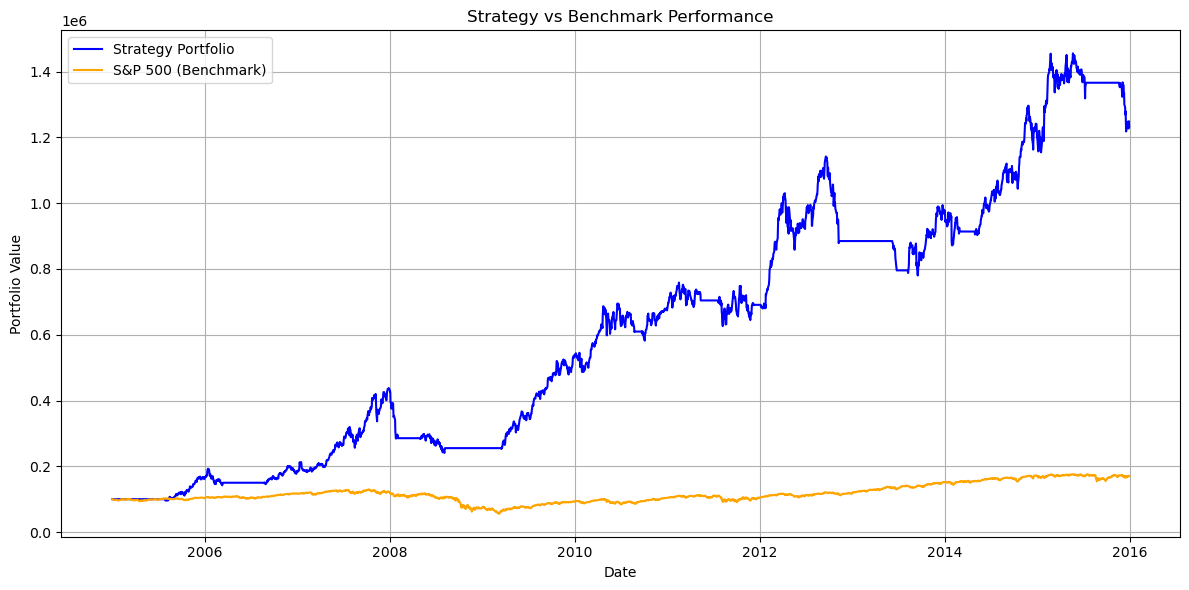

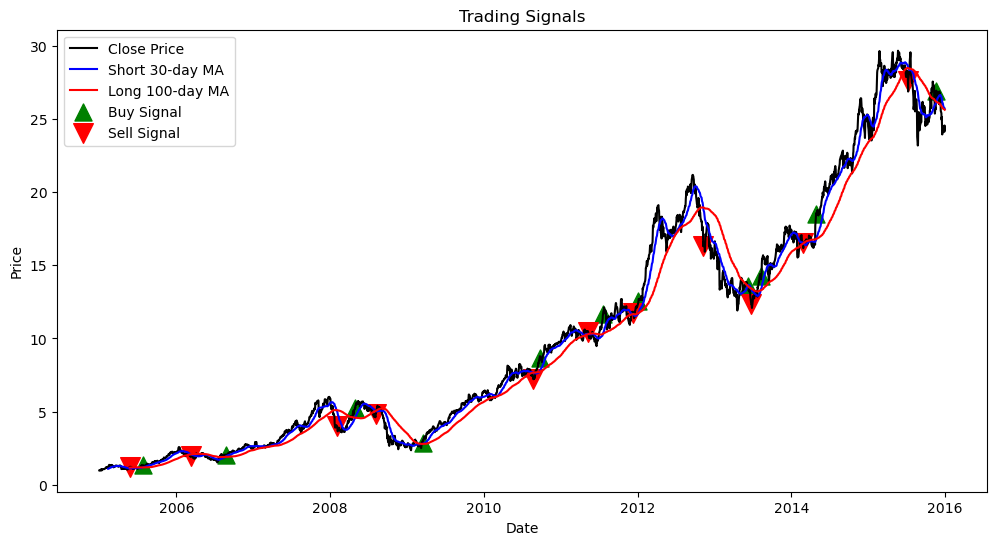

{'Final Value': 1233035.7036161646, 'Return': 11.330357036161645, 'Sharpe Ratio': 0.9567515284961486, 'Max Drawdown': -0.45027241247577277, 'Benchmark Return': 0.7025546509691731, 'Benchmark Sharpe Ratio': 0.2423450366797612, 'Benchmark Max Drawdown': -0.5677538774277291}


In [45]:
start_date = '2004-12-31'
end_date = '2015-12-31'
data_handler = DataHandler(ticker="AAPL", start_date=start_date, end_date=end_date)
data = data_handler.fetch_data()

# Load S&P 500 benchmark data
benchmark_data_handler = DataHandler("^GSPC", start_date, end_date)
benchmark_data = benchmark_data_handler.fetch_data()

moving_average_strategy = MovingAverage(short_window=30, long_window=100, mode='crossover', invert_signals=False)
backtest = Backtest(data, moving_average_strategy, benchmark_data, risk_free_rate=0.02)
results = backtest.run()
moving_average_strategy.plot_signals(data)
print(results)

## 1.1 Backtesting "In Sample"
We use our backtester across 100 tickers and all the different combinations of parameters we have defined. For each simulation, we store the results and we will select after the best parameters sets for an out of sample performance analysis.

In [52]:
import pandas as pd
from itertools import product

# Define tickers and parameter grid
tickers = tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AJG", "AKAM",
    "ALB", "AMAT", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON", "AOS", "APA",
    "APD", "APH", "ARE", "AVB", "AVY", "AXP", "AZO", "BA", "BAC", "BAX",
    "BBY", "BDX", "BEN", "BIIB", "BK", "BLK", "BMY", "BSX", "BXP", "C",
    "CAG", "CAH", "CAT", "CB", "CCI", "CDNS", "CHD", "CHRW", "CINF", "CL",
    "CLX", "CMI", "CNP", "COO", "COP", "COST", "CPB", "CPRT", "CSCO", "CTAS",
    "CTSH", "D", "DE", "DGX", "DHI", "DIS", "DLTR", "DOV", "DRI", "DTE",
    "DVA", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR",
    "EOG", "EQR", "ES", "ESS", "F", "FAST", "FCX", "FDX", "FE", "FFIV",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
]  # Extend list as needed

# Parameter grid
short_windows = [5, 10, 20, 30, 50]
long_windows = [50, 100, 150, 200, 300]
modes = ['crossover', 'single']
invert_flags = [True, False]

# Store results
all_results = {}
best_params = []

# Loop over tickers
for ticker in tickers:
    print(f"\n🔍 Evaluating {ticker}")
    data_handler = DataHandler(ticker=ticker, start_date=start_date, end_date=end_date)
    data = data_handler.fetch_data()

    results = []

    # Test each parameter combination
    for short_w, long_w, mode, invert in product(short_windows, long_windows, modes, invert_flags):
        if mode == 'crossover' and short_w >= long_w:
            continue

        strategy = MovingAverage(short_window=short_w, long_window=long_w, mode=mode, invert_signals=invert)
        backtest = Backtest(data, strategy, plot_results=False)

        try:
            result = backtest.run()
            results.append({
                'Ticker': ticker,
                'Short Window': short_w,
                'Long Window': long_w,
                'Mode': mode,
                'Invert Signals': invert,
                **result  # Includes Final Value, Return, Sharpe Ratio, Max Drawdown, etc.
            })
        except Exception as e:
            print(f"❌ Error for {ticker} | short={short_w} long={long_w} mode={mode} invert={invert}: {e}")
            continue

    # Save all results for this ticker
    all_results[ticker] = results

    # Create DataFrame and find best based on Sharpe Ratio
    if results:
        df = pd.DataFrame(results)
        best_row = df.loc[df['Sharpe Ratio'].idxmax()]
        best_params.append(best_row)

        # Optional: display the per-stock comparison table
        print(df[['Short Window', 'Long Window', 'Mode', 'Invert Signals', 'Return', 'Sharpe Ratio', 'Max Drawdown']].sort_values(by='Sharpe Ratio', ascending=False).head())
    else:
        print(f"⚠️ No results for {ticker}")

# Compile best strategy per stock
best_params_df = pd.DataFrame(best_params)

print("\n=== ✅ Summary of Best Parameters by Ticker ===")
print(best_params_df[['Ticker', 'Short Window', 'Long Window', 'Mode', 'Invert Signals', 'Sharpe Ratio', 'Return', 'Max Drawdown']].round(4))



[*********************100%***********************]  1 of 1 completed


🔍 Evaluating AAPL


    Short Window  Long Window       Mode  Invert Signals     Return  \
29            10          150  crossover           False  15.259825   
9              5          150  crossover           False  14.738577   
65            30          100  crossover           False  11.330357   
49            20          150  crossover           False  12.028148   
33            10          200  crossover           False  11.007116   

    Sharpe Ratio  Max Drawdown  
29      1.111913     -0.490606  
9       1.104167     -0.463435  
65      1.036386     -0.450272  
49      1.032465     -0.542200  
33      1.014743     -0.447550  

🔍 Evaluating ABT


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
52            20          200  crossover            True  0.762292   
90            50          200  crossover            True  0.693346   
32            10          200  crossover            True  0.643419   
56            20          300  crossover            True  0.482224   
94            50          300  crossover            True  0.471683   

    Sharpe Ratio  Max Drawdown  
52      0.496459     -0.147311  
90      0.473398     -0.268108  
32      0.438072     -0.148704  
56      0.405860     -0.164603  
94      0.397839     -0.268104  

🔍 Evaluating ADI


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.349059   
65            30          100  crossover           False  0.973678   
69            30          150  crossover           False  0.574531   
87            50          150  crossover           False  0.523914   
76            30          300  crossover            True  0.468999   

    Sharpe Ratio  Max Drawdown  
83      0.475425     -0.273750  
65      0.400139     -0.269283  
69      0.305994     -0.300121  
87      0.287741     -0.425777  
76      0.272024     -0.506516  

🔍 Evaluating ADM


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.180115   
5              5          100  crossover           False  1.011026   
65            30          100  crossover           False  0.941462   
45            20          100  crossover           False  0.828412   
87            50          150  crossover           False  0.827331   

    Sharpe Ratio  Max Drawdown  
83      0.439134     -0.353889  
5       0.390606     -0.373286  
65      0.383084     -0.376224  
45      0.356947     -0.398344  
87      0.356568     -0.414031  

🔍 Evaluating ADP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
64            30          100  crossover            True  1.278129   
37            10          300  crossover           False  1.030815   
17             5          300  crossover           False  0.925924   
57            20          300  crossover           False  0.896461   
87            50          150  crossover           False  0.823590   

    Sharpe Ratio  Max Drawdown  
64      0.579617     -0.182286  
37      0.506925     -0.194527  
17      0.477673     -0.243504  
57      0.461704     -0.271433  
87      0.455234     -0.275854  

🔍 Evaluating ADSK


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  0.615466   
69            30          150  crossover           False  0.456735   
91            50          200  crossover           False  0.382739   
40            20           50  crossover            True  0.289449   
94            50          300  crossover            True  0.288927   

    Sharpe Ratio  Max Drawdown  
87      0.303225     -0.464585  
69      0.263752     -0.400375  
91      0.243803     -0.374621  
40      0.225324     -0.647505  
94      0.224592     -0.716039  

🔍 Evaluating AEE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
64            30          100  crossover            True  0.328182   
77            30          300  crossover           False  0.268493   
95            50          300  crossover           False  0.163119   
44            20          100  crossover            True  0.159253   
68            30          150  crossover            True  0.116113   

    Sharpe Ratio  Max Drawdown  
64      0.237734     -0.442453  
77      0.224195     -0.321962  
95      0.168247     -0.400532  
44      0.163529     -0.410950  
68      0.144557     -0.556943  

🔍 Evaluating AEP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  1.280575   
37            10          300  crossover           False  1.226141   
57            20          300  crossover           False  1.207969   
17             5          300  crossover           False  1.169436   
77            30          300  crossover           False  1.178298   

    Sharpe Ratio  Max Drawdown  
95      0.578539     -0.231575  
37      0.571185     -0.234646  
57      0.563716     -0.235875  
17      0.556226     -0.223812  
77      0.554988     -0.237889  

🔍 Evaluating AJG


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.021475   
76            30          300  crossover            True  0.765379   
56            20          300  crossover            True  0.639753   
87            50          150  crossover           False  0.599799   
94            50          300  crossover            True  0.520058   

    Sharpe Ratio  Max Drawdown  
91      0.476158     -0.248827  
76      0.435334     -0.188164  
56      0.377426     -0.216843  
87      0.345417     -0.246697  
94      0.342974     -0.306036  

🔍 Evaluating AKAM


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
49            20          150  crossover           False  4.062790   
29            10          150  crossover           False  3.283584   
33            10          200  crossover           False  3.163372   
65            30          100  crossover           False  3.003467   
69            30          150  crossover           False  2.884460   

    Sharpe Ratio  Max Drawdown  
49      0.609542     -0.458397  
29      0.561590     -0.507323  
33      0.558932     -0.426747  
65      0.546110     -0.648572  
69      0.534105     -0.601956  

🔍 Evaluating ALB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
37            10          300  crossover           False  0.749566   
83            50          100  crossover           False  0.748620   
52            20          200  crossover            True  0.763860   
73            30          200  crossover           False  0.714946   
33            10          200  crossover           False  0.704127   

    Sharpe Ratio  Max Drawdown  
37      0.339226     -0.515977  
83      0.329731     -0.660040  
52      0.328425     -0.561619  
73      0.325720     -0.512032  
33      0.323627     -0.549135  

🔍 Evaluating AMAT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    Short Window  Long Window       Mode  Invert Signals    Return  \
25            10          100  crossover           False  0.302847   
53            20          200  crossover           False  0.292668   
49            20          150  crossover           False  0.239248   
45            20          100  crossover           False  0.190561   
9              5          150  crossover           False  0.168681   

    Sharpe Ratio  Max Drawdown  
25      0.219323     -0.445114  
53      0.216427     -0.458120  
49      0.198097     -0.455826  
45      0.181547     -0.425139  
9       0.172647     -0.455730  

🔍 Evaluating AMD


    Short Window  Long Window       Mode  Invert Signals    Return  \
69            30          150  crossover           False  1.642680   
49            20          150  crossover           False  1.387014   
87            50          150  crossover           False  1.255675   
33            10          200  crossover           False  0.918738   
29            10          150  crossover           False  0.823227   

    Sharpe Ratio  Max Drawdown  
69      0.442614     -0.549988  
49      0.411931     -0.559144  
87      0.393730     -0.582527  
33      0.348315     -0.595968  
29      0.331126     -0.562718  

🔍 Evaluating AME


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  2.835903   
83            50          100  crossover           False  2.447412   
77            30          300  crossover           False  2.453062   
91            50          200  crossover           False  2.465779   
73            30          200  crossover           False  2.292135   

    Sharpe Ratio  Max Drawdown  
87      0.696284     -0.309540  
83      0.674017     -0.212198  
77      0.651734     -0.277539  
91      0.647441     -0.326639  
73      0.627646     -0.287044  

🔍 Evaluating AMGN


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
86            50          150  crossover            True  0.787462   
90            50          200  crossover            True  0.713305   
76            30          300  crossover            True  0.689493   
72            30          200  crossover            True  0.476646   
68            30          150  crossover            True  0.453525   

    Sharpe Ratio  Max Drawdown  
86      0.419856     -0.373796  
90      0.398549     -0.385964  
76      0.393560     -0.472817  
72      0.309580     -0.390320  
68      0.295646     -0.390769  

🔍 Evaluating AMT


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  2.196128   
45            20          100  crossover           False  1.788356   
53            20          200  crossover           False  1.615463   
65            30          100  crossover           False  1.509813   
73            30          200  crossover           False  1.324335   

    Sharpe Ratio  Max Drawdown  
91      0.620298     -0.361837  
45      0.563476     -0.346583  
53      0.539842     -0.442271  
65      0.511476     -0.383800  
73      0.485753     -0.415603  

🔍 Evaluating AMZN


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  8.532413   
57            20          300  crossover           False  7.048376   
83            50          100  crossover           False  6.372037   
73            30          200  crossover           False  5.311201   
77            30          300  crossover           False  5.300348   

    Sharpe Ratio  Max Drawdown  
95      0.813417     -0.380775  
57      0.757629     -0.441475  
83      0.713936     -0.416309  
73      0.688011     -0.428990  
77      0.683430     -0.479951  

🔍 Evaluating AON


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
94            50          300  crossover            True  1.127797   
83            50          100  crossover           False  1.460861   
45            20          100  crossover           False  1.397274   
65            30          100  crossover           False  1.381153   
90            50          200  crossover            True  1.034480   

    Sharpe Ratio  Max Drawdown  
94      0.567601     -0.226627  
83      0.549001     -0.388845  
45      0.543380     -0.385786  
65      0.526079     -0.436230  
90      0.510643     -0.226642  

🔍 Evaluating AOS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  7.178715   
83            50          100  crossover           False  4.672138   
91            50          200  crossover           False  4.703611   
53            20          200  crossover           False  4.112417   
69            30          150  crossover           False  3.959937   

    Sharpe Ratio  Max Drawdown  
87      0.891327     -0.431700  
83      0.757164     -0.484230  
91      0.747218     -0.584586  
53      0.728435     -0.482220  
69      0.705835     -0.550556  

🔍 Evaluating APA


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
60            30           50  crossover            True  0.121074   
91            50          200  crossover           False  0.126236   
20            10           50  crossover            True -0.069168   
76            30          300  crossover            True -0.083938   
40            20           50  crossover            True -0.117173   

    Sharpe Ratio  Max Drawdown  
60      0.182593     -0.589810  
91      0.157173     -0.543180  
20      0.123211     -0.648357  
76      0.116936     -0.597936  
40      0.110765     -0.647436  

🔍 Evaluating APD


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.690449   
73            30          200  crossover           False  1.626398   
49            20          150  crossover           False  1.443486   
69            30          150  crossover           False  1.396370   
53            20          200  crossover           False  1.213388   

    Sharpe Ratio  Max Drawdown  
83      0.580517     -0.263134  
73      0.570058     -0.330965  
49      0.543517     -0.310552  
69      0.533274     -0.357070  
53      0.486891     -0.307545  

🔍 Evaluating APH


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  2.909396   
69            30          150  crossover           False  2.615322   
73            30          200  crossover           False  2.479979   
65            30          100  crossover           False  2.420374   
33            10          200  crossover           False  2.346997   

    Sharpe Ratio  Max Drawdown  
83      0.650555     -0.421681  
69      0.618144     -0.396538  
73      0.607136     -0.462113  
65      0.598288     -0.318441  
33      0.594924     -0.317221  

🔍 Evaluating ARE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
60            30           50  crossover            True  0.480220   
76            30          300  crossover            True  0.399222   
40            20           50  crossover            True  0.380921   
33            10          200  crossover           False  0.355029   
72            30          200  crossover            True  0.219351   

    Sharpe Ratio  Max Drawdown  
60      0.269351     -0.652947  
76      0.251902     -0.558706  
40      0.247379     -0.658663  
33      0.237163     -0.412475  
72      0.208639     -0.558686  

🔍 Evaluating AVB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  3.150847   
73            30          200  crossover           False  2.756829   
69            30          150  crossover           False  2.660274   
77            30          300  crossover           False  2.204560   
95            50          300  crossover           False  1.956588   

    Sharpe Ratio  Max Drawdown  
87      0.698146     -0.345557  
73      0.673507     -0.422180  
69      0.653018     -0.451174  
77      0.649522     -0.275238  
95      0.620893     -0.314466  

🔍 Evaluating AVY


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.253951   
73            30          200  crossover           False  0.877113   
37            10          300  crossover           False  0.836159   
77            30          300  crossover           False  0.690326   
33            10          200  crossover           False  0.679259   

    Sharpe Ratio  Max Drawdown  
91      0.509505     -0.282290  
73      0.421766     -0.352992  
37      0.402060     -0.380462  
77      0.359323     -0.294751  
33      0.356180     -0.388333  

🔍 Evaluating AXP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
77            30          300  crossover           False  1.853576   
57            20          300  crossover           False  1.790013   
95            50          300  crossover           False  1.674654   
37            10          300  crossover           False  1.563007   
73            30          200  crossover           False  1.574674   

    Sharpe Ratio  Max Drawdown  
77      0.574221     -0.215162  
57      0.566387     -0.222575  
95      0.543137     -0.216449  
37      0.528552     -0.224696  
73      0.518929     -0.272322  

🔍 Evaluating AZO


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  3.786302   
73            30          200  crossover           False  2.541895   
77            30          300  crossover           False  2.323947   
87            50          150  crossover           False  2.199498   
17             5          300  crossover           False  2.091290   

    Sharpe Ratio  Max Drawdown  
95      0.831340     -0.306527  
73      0.732000     -0.300007  
77      0.686377     -0.483415  
87      0.668756     -0.346912  
17      0.659139     -0.494903  

🔍 Evaluating BA


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
57            20          300  crossover           False  1.819161   
95            50          300  crossover           False  1.693720   
77            30          300  crossover           False  1.561769   
65            30          100  crossover           False  1.364102   
45            20          100  crossover           False  1.318205   

    Sharpe Ratio  Max Drawdown  
57      0.595058     -0.289655  
95      0.566492     -0.273213  
77      0.545004     -0.286678  
65      0.514119     -0.411713  
45      0.506838     -0.395013  

🔍 Evaluating BAC


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
45            20          100  crossover           False  0.542195   
73            30          200  crossover           False  0.453905   
53            20          200  crossover           False  0.442630   
95            50          300  crossover           False  0.411327   
25            10          100  crossover           False  0.452413   

    Sharpe Ratio  Max Drawdown  
45      0.282211     -0.519035  
73      0.269881     -0.445890  
53      0.266399     -0.436624  
95      0.266314     -0.338137  
25      0.263293     -0.541612  

🔍 Evaluating BAX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
94            50          300  crossover            True  1.368461   
90            50          200  crossover            True  1.059521   
86            50          150  crossover            True  0.985585   
56            20          300  crossover            True  0.876501   
72            30          200  crossover            True  0.740189   

    Sharpe Ratio  Max Drawdown  
94      0.764900     -0.224732  
90      0.577360     -0.224739  
86      0.523751     -0.240417  
56      0.521528     -0.240406  
72      0.451146     -0.240411  

🔍 Evaluating BBY


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
86            50          150  crossover            True  0.765877   
82            50          100  crossover            True  0.748731   
64            30          100  crossover            True  0.626138   
56            20          300  crossover            True  0.453421   
94            50          300  crossover            True  0.330581   

    Sharpe Ratio  Max Drawdown  
86      0.321672     -0.595681  
82      0.318909     -0.573386  
64      0.296811     -0.527335  
56      0.263927     -0.665493  
94      0.238577     -0.664048  

🔍 Evaluating BDX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
57            20          300  crossover           False  1.487986   
91            50          200  crossover           False  1.571962   
37            10          300  crossover           False  1.342709   
77            30          300  crossover           False  1.334180   
73            30          200  crossover           False  1.360826   

    Sharpe Ratio  Max Drawdown  
57      0.650995     -0.270182  
91      0.645757     -0.222912  
37      0.610656     -0.277962  
77      0.605244     -0.285973  
73      0.593457     -0.297295  

🔍 Evaluating BEN


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
5              5          100  crossover           False  0.776869   
77            30          300  crossover           False  0.626537   
53            20          200  crossover           False  0.584333   
49            20          150  crossover           False  0.568454   
45            20          100  crossover           False  0.521518   

    Sharpe Ratio  Max Drawdown  
5       0.365405     -0.435347  
77      0.321895     -0.325229  
53      0.308428     -0.338242  
49      0.298619     -0.371671  
45      0.285945     -0.456107  

🔍 Evaluating BIIB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
37            10          300  crossover           False  2.818733   
73            30          200  crossover           False  2.594831   
20            10           50  crossover            True  1.890370   
83            50          100  crossover           False  2.254658   
28            10          150  crossover            True  1.592351   

    Sharpe Ratio  Max Drawdown  
37      0.570818     -0.540501  
73      0.567099     -0.518536  
20      0.558774     -0.285947  
83      0.548930     -0.588959  
28      0.545834     -0.299587  

🔍 Evaluating BK


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  0.480583   
73            30          200  crossover           False  0.429573   
69            30          150  crossover           False  0.432893   
87            50          150  crossover           False  0.406057   
60            30           50  crossover            True  0.340007   

    Sharpe Ratio  Max Drawdown  
83      0.278417     -0.291109  
73      0.261780     -0.491661  
69      0.259940     -0.331510  
87      0.253971     -0.416934  
60      0.248478     -0.464431  

🔍 Evaluating BLK


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
65            30          100  crossover           False  3.023502   
53            20          200  crossover           False  2.363706   
49            20          150  crossover           False  2.234775   
45            20          100  crossover           False  2.135370   
87            50          150  crossover           False  2.088987   

    Sharpe Ratio  Max Drawdown  
65      0.639142     -0.482528  
53      0.569657     -0.419989  
49      0.550677     -0.522783  
45      0.548035     -0.524444  
87      0.530522     -0.543504  

🔍 Evaluating BMY


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  2.571377   
77            30          300  crossover           False  2.003196   
57            20          300  crossover           False  1.795419   
91            50          200  crossover           False  1.717922   
73            30          200  crossover           False  1.484628   

    Sharpe Ratio  Max Drawdown  
95      0.692305     -0.449049  
77      0.622110     -0.397459  
57      0.590953     -0.402107  
91      0.578133     -0.370233  
73      0.540161     -0.315545  

🔍 Evaluating BSX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
49            20          150  crossover           False  0.881781   
69            30          150  crossover           False  0.773356   
37            10          300  crossover           False  0.691536   
87            50          150  crossover           False  0.699515   
95            50          300  crossover           False  0.575342   

    Sharpe Ratio  Max Drawdown  
49      0.397172     -0.340671  
69      0.367553     -0.418219  
37      0.352603     -0.523474  
87      0.348840     -0.367560  
95      0.316955     -0.438045  

🔍 Evaluating BXP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
49            20          150  crossover           False  1.688065   
87            50          150  crossover           False  1.720082   
69            30          150  crossover           False  1.614117   
29            10          150  crossover           False  1.306797   
33            10          200  crossover           False  1.214862   

    Sharpe Ratio  Max Drawdown  
49      0.515302     -0.408531  
87      0.511829     -0.445748  
69      0.500646     -0.438915  
29      0.454275     -0.472871  
33      0.452434     -0.409099  

🔍 Evaluating C


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  0.052791   
77            30          300  crossover           False -0.102608   
37            10          300  crossover           False -0.121414   
72            30          200  crossover            True -0.812601   
90            50          200  crossover            True -0.828951   

    Sharpe Ratio  Max Drawdown  
95      0.113411     -0.406500  
77      0.027157     -0.388067  
37      0.014888     -0.409201  
72     -0.002096     -0.977866  
90     -0.016874     -0.977834  

🔍 Evaluating CAG


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  1.065615   
77            30          300  crossover           False  1.079357   
53            20          200  crossover           False  0.956333   
73            30          200  crossover           False  0.953640   
57            20          300  crossover           False  0.917599   

    Sharpe Ratio  Max Drawdown  
95      0.536608     -0.234922  
77      0.528041     -0.289112  
53      0.492701     -0.291735  
73      0.491324     -0.284807  
57      0.479956     -0.251563  

🔍 Evaluating CAH


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.953838   
87            50          150  crossover           False  1.339267   
91            50          200  crossover           False  1.312377   
73            30          200  crossover           False  1.292261   
69            30          150  crossover           False  1.113294   

    Sharpe Ratio  Max Drawdown  
83      0.702610     -0.277199  
87      0.598413     -0.257950  
91      0.581506     -0.259471  
73      0.577517     -0.327707  
69      0.513146     -0.343460  

🔍 Evaluating CAT


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  2.030826   
87            50          150  crossover           False  1.847126   
69            30          150  crossover           False  1.798946   
65            30          100  crossover           False  1.461525   
91            50          200  crossover           False  1.145702   

    Sharpe Ratio  Max Drawdown  
83      0.604364     -0.392661  
87      0.565748     -0.392652  
69      0.549121     -0.394009  
65      0.506060     -0.388131  
91      0.443116     -0.544752  

🔍 Evaluating CB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
24            10          100  crossover            True  1.427265   
4              5          100  crossover            True  1.102902   
77            30          300  crossover           False  0.820530   
57            20          300  crossover           False  0.765903   
37            10          300  crossover           False  0.698744   

    Sharpe Ratio  Max Drawdown  
24      0.476655     -0.360240  
4       0.414456     -0.360209  
77      0.401712     -0.245906  
57      0.387586     -0.241596  
37      0.363959     -0.274825  

🔍 Evaluating CCI


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  2.849148   
95            50          300  crossover           False  1.719067   
91            50          200  crossover           False  1.734254   
87            50          150  crossover           False  1.715732   
65            30          100  crossover           False  1.876266   

    Sharpe Ratio  Max Drawdown  
83      0.673196     -0.306829  
95      0.553355     -0.327397  
91      0.548944     -0.306321  
87      0.545596     -0.335723  
65      0.538389     -0.412407  

🔍 Evaluating CDNS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
25            10          100  crossover           False  2.226191   
45            20          100  crossover           False  1.416442   
95            50          300  crossover           False  1.168501   
73            30          200  crossover           False  1.099085   
29            10          150  crossover           False  1.033121   

    Sharpe Ratio  Max Drawdown  
25      0.582930     -0.379871  
45      0.461777     -0.383356  
95      0.423048     -0.391042  
73      0.416737     -0.355333  
29      0.404132     -0.427890  

🔍 Evaluating CHD


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  3.958047   
57            20          300  crossover           False  3.492210   
77            30          300  crossover           False  3.444539   
17             5          300  crossover           False  2.979552   
37            10          300  crossover           False  2.934670   

    Sharpe Ratio  Max Drawdown  
95      0.943227     -0.212854  
57      0.893916     -0.250964  
77      0.884695     -0.264177  
17      0.829598     -0.233195  
37      0.825680     -0.263661  

🔍 Evaluating CHRW


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
32            10          200  crossover            True  1.373093   
12             5          200  crossover            True  1.320353   
40            20           50  crossover            True  1.281329   
52            20          200  crossover            True  1.125004   
16             5          300  crossover            True  1.056091   

    Sharpe Ratio  Max Drawdown  
32      0.468838     -0.316319  
12      0.463032     -0.291506  
40      0.461167     -0.253875  
52      0.422918     -0.316360  
16      0.418398     -0.282883  

🔍 Evaluating CINF


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.667946   
95            50          300  crossover           False  1.292685   
77            30          300  crossover           False  1.240779   
73            30          200  crossover           False  1.236059   
57            20          300  crossover           False  1.106280   

    Sharpe Ratio  Max Drawdown  
91      0.754956     -0.225001  
95      0.653026     -0.216259  
77      0.636036     -0.199093  
73      0.625763     -0.278713  
57      0.589918     -0.238108  

🔍 Evaluating CL


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
69            30          150  crossover           False  1.190001   
91            50          200  crossover           False  1.146336   
73            30          200  crossover           False  0.975691   
94            50          300  crossover            True  0.605736   
87            50          150  crossover           False  0.835630   

    Sharpe Ratio  Max Drawdown  
69      0.561906     -0.315950  
91      0.550174     -0.325324  
73      0.499150     -0.314240  
94      0.476316     -0.200792  
87      0.450998     -0.414665  

🔍 Evaluating CLX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
73            30          200  crossover           False  1.052667   
77            30          300  crossover           False  0.906883   
17             5          300  crossover           False  0.843106   
53            20          200  crossover           False  0.860998   
37            10          300  crossover           False  0.839854   

    Sharpe Ratio  Max Drawdown  
73      0.517416     -0.309775  
77      0.463150     -0.367743  
17      0.456515     -0.358773  
53      0.454007     -0.292555  
37      0.449892     -0.399760  

🔍 Evaluating CMI


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  6.548396   
13             5          200  crossover           False  4.029352   
49            20          150  crossover           False  3.560802   
33            10          200  crossover           False  3.001378   
9              5          150  crossover           False  2.979953   

    Sharpe Ratio  Max Drawdown  
83      0.784636     -0.410151  
13      0.660135     -0.419708  
49      0.615860     -0.478197  
33      0.586057     -0.573273  
9       0.575708     -0.500705  

🔍 Evaluating CNP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  1.396256   
57            20          300  crossover           False  0.945588   
37            10          300  crossover           False  0.892969   
77            30          300  crossover           False  0.888426   
53            20          200  crossover           False  0.638197   

    Sharpe Ratio  Max Drawdown  
95      0.590397     -0.284556  
57      0.465310     -0.420785  
37      0.454858     -0.351321  
77      0.447171     -0.427546  
53      0.373393     -0.387957  

🔍 Evaluating COO


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
37            10          300  crossover           False  2.057825   
77            30          300  crossover           False  1.876989   
61            30           50  crossover           False  1.800286   
17             5          300  crossover           False  1.595059   
57            20          300  crossover           False  1.591944   

    Sharpe Ratio  Max Drawdown  
37      0.612433     -0.355690  
77      0.574438     -0.395356  
61      0.538130     -0.370450  
17      0.535510     -0.444251  
57      0.529706     -0.450295  

🔍 Evaluating COP


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
77            30          300  crossover           False  1.091073   
57            20          300  crossover           False  1.005035   
95            50          300  crossover           False  1.030266   
37            10          300  crossover           False  0.610078   
91            50          200  crossover           False  0.422833   

    Sharpe Ratio  Max Drawdown  
77      0.455453     -0.281165  
57      0.436265     -0.290526  
95      0.434109     -0.303632  
37      0.328111     -0.310754  
91      0.264085     -0.366113  

🔍 Evaluating COST


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  2.630175   
73            30          200  crossover           False  2.243271   
87            50          150  crossover           False  1.951349   
53            20          200  crossover           False  1.943406   
95            50          300  crossover           False  1.978300   

    Sharpe Ratio  Max Drawdown  
91      0.756085     -0.191648  
73      0.702150     -0.219776  
87      0.657734     -0.310395  
53      0.649430     -0.283610  
95      0.637150     -0.314800  

🔍 Evaluating CPB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  0.660330   
95            50          300  crossover           False  0.529860   
91            50          200  crossover           False  0.408090   
36            10          300  crossover            True  0.312868   
40            20           50  crossover            True  0.336831   

    Sharpe Ratio  Max Drawdown  
87      0.393246     -0.295410  
95      0.336738     -0.390813  
91      0.289466     -0.363264  
36      0.284960     -0.220188  
40      0.270958     -0.329486  

🔍 Evaluating CPRT


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
52            20          200  crossover            True  1.232671   
86            50          150  crossover            True  1.130191   
90            50          200  crossover            True  1.066159   
72            30          200  crossover            True  1.075272   
28            10          150  crossover            True  0.867294   

    Sharpe Ratio  Max Drawdown  
52      0.521399     -0.360966  
86      0.492853     -0.367293  
90      0.491199     -0.351528  
72      0.481783     -0.360965  
28      0.417346     -0.414085  

🔍 Evaluating CSCO


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
53            20          200  crossover           False  0.337487   
73            30          200  crossover           False  0.305748   
95            50          300  crossover           False  0.303752   
44            20          100  crossover            True  0.301335   
56            20          300  crossover            True  0.281942   

    Sharpe Ratio  Max Drawdown  
53      0.236542     -0.358531  
73      0.224878     -0.369369  
95      0.223862     -0.379705  
44      0.218311     -0.512047  
56      0.213155     -0.529739  

🔍 Evaluating CTAS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
82            50          100  crossover            True  1.234896   
86            50          150  crossover            True  1.053829   
64            30          100  crossover            True  1.020212   
95            50          300  crossover           False  0.818197   
90            50          200  crossover            True  0.842490   

    Sharpe Ratio  Max Drawdown  
82      0.495735     -0.377009  
86      0.456618     -0.369285  
64      0.435047     -0.345167  
95      0.418772     -0.379891  
90      0.399831     -0.405131  

🔍 Evaluating CTSH


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  3.659939   
73            30          200  crossover           False  2.939503   
91            50          200  crossover           False  2.711584   
53            20          200  crossover           False  1.979223   
87            50          150  crossover           False  2.005059   

    Sharpe Ratio  Max Drawdown  
83      0.681909     -0.373444  
73      0.651252     -0.399764  
91      0.622161     -0.382719  
53      0.542164     -0.454541  
87      0.538743     -0.432318  

🔍 Evaluating D


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.220019   
37            10          300  crossover           False  1.131597   
77            30          300  crossover           False  1.132326   
57            20          300  crossover           False  1.134722   
95            50          300  crossover           False  1.127180   

    Sharpe Ratio  Max Drawdown  
83      0.601230     -0.225587  
37      0.566015     -0.233973  
77      0.565812     -0.296537  
57      0.565026     -0.267371  
95      0.556192     -0.282022  

🔍 Evaluating DE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
45            20          100  crossover           False  2.245184   
49            20          150  crossover           False  2.020242   
29            10          150  crossover           False  1.990150   
53            20          200  crossover           False  1.823848   
33            10          200  crossover           False  1.735190   

    Sharpe Ratio  Max Drawdown  
45      0.584649     -0.351418  
49      0.552040     -0.366523  
29      0.547832     -0.336026  
53      0.531018     -0.426757  
33      0.517469     -0.429749  

🔍 Evaluating DGX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
76            30          300  crossover            True  1.458081   
52            20          200  crossover            True  1.418054   
94            50          300  crossover            True  1.213278   
72            30          200  crossover            True  1.180631   
56            20          300  crossover            True  1.180732   

    Sharpe Ratio  Max Drawdown  
76      0.605443     -0.237064  
52      0.589065     -0.238908  
94      0.548253     -0.225337  
72      0.531126     -0.204039  
56      0.526209     -0.221518  

🔍 Evaluating DHI


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
20            10           50  crossover            True  1.036695   
40            20           50  crossover            True  0.765013   
64            30          100  crossover            True  0.581392   
82            50          100  crossover            True  0.478808   
52            20          200  crossover            True  0.307568   

    Sharpe Ratio  Max Drawdown  
20      0.355921     -0.755607  
40      0.321966     -0.728912  
64      0.297535     -0.698754  
82      0.281162     -0.684281  
52      0.264829     -0.792287  

🔍 Evaluating DIS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  3.500022   
83            50          100  crossover           False  2.735176   
17             5          300  crossover           False  2.647433   
95            50          300  crossover           False  2.587583   
77            30          300  crossover           False  2.532093   

    Sharpe Ratio  Max Drawdown  
87      0.880881     -0.241171  
83      0.780323     -0.244391  
17      0.756168     -0.304780  
95      0.751814     -0.292633  
77      0.741019     -0.284293  

🔍 Evaluating DLTR


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
25            10          100  crossover           False  5.990499   
69            30          150  crossover           False  6.589877   
87            50          150  crossover           False  6.000677   
83            50          100  crossover           False  5.143714   
45            20          100  crossover           False  5.040516   

    Sharpe Ratio  Max Drawdown  
25      0.892371     -0.283682  
69      0.886075     -0.233934  
87      0.854987     -0.233492  
83      0.839816     -0.254034  
45      0.837054     -0.287396  

🔍 Evaluating DOV


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.312101   
65            30          100  crossover           False  1.046716   
45            20          100  crossover           False  0.932907   
77            30          300  crossover           False  0.784516   
37            10          300  crossover           False  0.710893   

    Sharpe Ratio  Max Drawdown  
83      0.509087     -0.290346  
65      0.445109     -0.304739  
45      0.418730     -0.305146  
77      0.371862     -0.406729  
37      0.359120     -0.341466  

🔍 Evaluating DRI


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
32            10          200  crossover            True  1.802524   
90            50          200  crossover            True  1.560922   
52            20          200  crossover            True  1.534045   
86            50          150  crossover            True  1.377743   
72            30          200  crossover            True  1.068891   

    Sharpe Ratio  Max Drawdown  
32      0.494451     -0.590425  
90      0.479358     -0.478894  
52      0.460666     -0.616298  
86      0.446854     -0.606067  
72      0.393680     -0.549031  

🔍 Evaluating DTE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  2.074372   
57            20          300  crossover           False  1.798639   
17             5          300  crossover           False  1.617444   
77            30          300  crossover           False  1.592149   
37            10          300  crossover           False  1.582879   

    Sharpe Ratio  Max Drawdown  
95      0.797153     -0.214598  
57      0.731400     -0.260774  
17      0.686851     -0.238149  
77      0.682892     -0.288890  
37      0.678494     -0.287089  

🔍 Evaluating DVA


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  0.978350   
94            50          300  crossover            True  0.835165   
90            50          200  crossover            True  0.655890   
69            30          150  crossover           False  0.754728   
65            30          100  crossover           False  0.671494   

    Sharpe Ratio  Max Drawdown  
83      0.436410     -0.402147  
94      0.424193     -0.253898  
90      0.381624     -0.238171  
69      0.380458     -0.446452  
65      0.354663     -0.369264  

🔍 Evaluating EA


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  1.762022   
37            10          300  crossover           False  1.633716   
91            50          200  crossover           False  1.338756   
17             5          300  crossover           False  1.063684   
69            30          150  crossover           False  1.066304   

    Sharpe Ratio  Max Drawdown  
95      0.512884     -0.367962  
37      0.491364     -0.438406  
91      0.437779     -0.471506  
17      0.397384     -0.595135  
69      0.388990     -0.580990  

🔍 Evaluating EBAY


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  1.169370   
91            50          200  crossover           False  0.941402   
57            20          300  crossover           False  0.841296   
77            30          300  crossover           False  0.719329   
73            30          200  crossover           False  0.439047   

    Sharpe Ratio  Max Drawdown  
87      0.419860     -0.326323  
91      0.373974     -0.287911  
57      0.358897     -0.295290  
77      0.330228     -0.323891  
73      0.257519     -0.342807  

🔍 Evaluating ECL


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.562357   
68            30          150  crossover            True  0.880708   
86            50          150  crossover            True  0.866923   
95            50          300  crossover           False  0.998499   
48            20          150  crossover            True  0.720744   

    Sharpe Ratio  Max Drawdown  
91      0.557417     -0.327614  
68      0.481681     -0.259632  
86      0.479531     -0.233617  
95      0.430113     -0.339186  
48      0.416538     -0.296574  

🔍 Evaluating ED


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
90            50          200  crossover            True  0.583096   
72            30          200  crossover            True  0.536015   
52            20          200  crossover            True  0.451836   
56            20          300  crossover            True  0.534389   
36            10          300  crossover            True  0.393454   

    Sharpe Ratio  Max Drawdown  
90      0.488109     -0.204382  
72      0.471429     -0.143754  
52      0.414687     -0.134083  
56      0.411926     -0.207566  
36      0.339752     -0.174276  

🔍 Evaluating EFX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
73            30          200  crossover           False  2.096233   
91            50          200  crossover           False  1.906489   
53            20          200  crossover           False  1.901116   
57            20          300  crossover           False  1.594667   
25            10          100  crossover           False  1.609171   

    Sharpe Ratio  Max Drawdown  
73      0.703750     -0.398990  
91      0.679590     -0.326062  
53      0.668522     -0.425064  
57      0.628013     -0.349529  
25      0.620509     -0.355257  

🔍 Evaluating EIX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  0.671522   
77            30          300  crossover           False  0.585065   
69            30          150  crossover           False  0.579382   
91            50          200  crossover           False  0.561346   
95            50          300  crossover           False  0.548652   

    Sharpe Ratio  Max Drawdown  
87      0.375509     -0.273157  
77      0.349746     -0.230289  
69      0.345708     -0.285761  
91      0.343156     -0.244987  
95      0.332317     -0.256748  

🔍 Evaluating EL


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  2.246501   
91            50          200  crossover           False  1.749248   
64            30          100  crossover            True  1.487275   
48            20          150  crossover            True  1.498715   
77            30          300  crossover           False  1.661073   

    Sharpe Ratio  Max Drawdown  
95      0.570699     -0.436475  
91      0.519602     -0.443557  
64      0.504864     -0.447029  
48      0.502075     -0.480229  
77      0.498107     -0.474674  

🔍 Evaluating EMN


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
45            20          100  crossover           False  2.446234   
65            30          100  crossover           False  1.346106   
69            30          150  crossover           False  1.276297   
73            30          200  crossover           False  1.037800   
91            50          200  crossover           False  0.816018   

    Sharpe Ratio  Max Drawdown  
45      0.612525     -0.305816  
65      0.455416     -0.330400  
69      0.446525     -0.372175  
73      0.401578     -0.411981  
91      0.354773     -0.428784  

🔍 Evaluating EMR


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.587364   
53            20          200  crossover           False  1.132985   
73            30          200  crossover           False  0.990771   
87            50          150  crossover           False  0.841930   
77            30          300  crossover           False  0.621426   

    Sharpe Ratio  Max Drawdown  
91      0.576610     -0.310563  
53      0.482346     -0.313607  
73      0.443956     -0.343087  
87      0.405511     -0.325271  
77      0.339803     -0.452844  

🔍 Evaluating EOG


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
45            20          100  crossover           False  1.105209   
65            30          100  crossover           False  1.041122   
61            30           50  crossover           False  1.000889   
95            50          300  crossover           False  0.772387   
69            30          150  crossover           False  0.778153   

    Sharpe Ratio  Max Drawdown  
45      0.393460     -0.410162  
65      0.382813     -0.455178  
61      0.371521     -0.553634  
95      0.332208     -0.499446  
69      0.331756     -0.441816  

🔍 Evaluating EQR


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  2.014306   
87            50          150  crossover           False  1.905113   
91            50          200  crossover           False  1.452949   
69            30          150  crossover           False  1.243360   
73            30          200  crossover           False  1.173936   

    Sharpe Ratio  Max Drawdown  
83      0.523500     -0.513915  
87      0.510645     -0.434622  
91      0.453298     -0.429780  
69      0.417985     -0.468636  
73      0.409095     -0.417362  

🔍 Evaluating ES


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
95            50          300  crossover           False  2.335591   
57            20          300  crossover           False  2.275575   
77            30          300  crossover           False  2.223237   
17             5          300  crossover           False  2.208034   
37            10          300  crossover           False  2.109604   

    Sharpe Ratio  Max Drawdown  
95      0.800016     -0.286586  
57      0.792903     -0.258932  
77      0.782938     -0.277683  
17      0.781335     -0.246138  
37      0.761761     -0.266323  

🔍 Evaluating ESS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  2.709489   
83            50          100  crossover           False  2.774111   
91            50          200  crossover           False  2.525087   
73            30          200  crossover           False  2.152421   
33            10          200  crossover           False  1.958250   

    Sharpe Ratio  Max Drawdown  
87      0.646487     -0.346396  
83      0.641787     -0.441640  
91      0.617745     -0.368736  
73      0.579447     -0.366275  
33      0.574441     -0.368284  

🔍 Evaluating F


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
25            10          100  crossover           False  1.707492   
95            50          300  crossover           False  1.296330   
9              5          150  crossover           False  1.155010   
45            20          100  crossover           False  1.010466   
29            10          150  crossover           False  0.946242   

    Sharpe Ratio  Max Drawdown  
25      0.477196     -0.511408  
95      0.450685     -0.327058  
9       0.398729     -0.554183  
45      0.372620     -0.645198  
29      0.362949     -0.536709  

🔍 Evaluating FAST


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
48            20          150  crossover            True  1.599003   
60            30           50  crossover            True  1.633521   
36            10          300  crossover            True  1.402899   
76            30          300  crossover            True  1.223437   
64            30          100  crossover            True  1.280928   

    Sharpe Ratio  Max Drawdown  
48      0.492597     -0.363365  
60      0.484744     -0.329833  
36      0.473745     -0.363373  
76      0.458122     -0.363369  
64      0.444788     -0.363368  

🔍 Evaluating FCX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
83            50          100  crossover           False  1.878909   
65            30          100  crossover           False  1.697209   
45            20          100  crossover           False  0.801865   
77            30          300  crossover           False  0.775186   
57            20          300  crossover           False  0.549623   

    Sharpe Ratio  Max Drawdown  
83      0.470154     -0.529118  
65      0.450660     -0.598728  
45      0.329497     -0.594456  
77      0.325625     -0.432725  
57      0.283954     -0.489390  

🔍 Evaluating FDX


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
87            50          150  crossover           False  0.672323   
73            30          200  crossover           False  0.625659   
57            20          300  crossover           False  0.515966   
77            30          300  crossover           False  0.513010   
95            50          300  crossover           False  0.464280   

    Sharpe Ratio  Max Drawdown  
87      0.355375     -0.420925  
73      0.342543     -0.368851  
57      0.298858     -0.318704  
77      0.296319     -0.364240  
95      0.279323     -0.324082  

🔍 Evaluating FE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
17             5          300  crossover           False  0.210117   
60            30           50  crossover            True  0.169982   
29            10          150  crossover           False  0.149433   
95            50          300  crossover           False  0.095737   
25            10          100  crossover           False  0.095165   

    Sharpe Ratio  Max Drawdown  
17      0.191031     -0.331038  
60      0.168943     -0.387189  
29      0.159815     -0.328068  
95      0.131574     -0.429315  
25      0.130251     -0.338996  

🔍 Evaluating FFIV


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
94            50          300  crossover            True  2.457643   
90            50          200  crossover            True  1.880038   
76            30          300  crossover            True  1.807505   
29            10          150  crossover           False  1.690698   
72            30          200  crossover            True  1.634815   

    Sharpe Ratio  Max Drawdown  
94      0.535417     -0.398497  
90      0.471869     -0.416283  
76      0.469674     -0.398496  
29      0.448507     -0.486414  
72      0.440286     -0.416344  

🔍 Evaluating FITB


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
69            30          150  crossover           False  1.230792   
53            20          200  crossover           False  1.132709   
91            50          200  crossover           False  0.969881   
87            50          150  crossover           False  0.863186   
73            30          200  crossover           False  0.770928   

    Sharpe Ratio  Max Drawdown  
69      0.439935     -0.265075  
53      0.428309     -0.393056  
91      0.391140     -0.391196  
87      0.367174     -0.304786  
73      0.347510     -0.378840  

🔍 Evaluating FRT


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
33            10          200  crossover           False  1.554488   
95            50          300  crossover           False  1.011002   
64            30          100  crossover            True  1.204060   
60            30           50  crossover            True  1.036514   
25            10          100  crossover           False  0.881597   

    Sharpe Ratio  Max Drawdown  
33      0.528406     -0.450719  
95      0.444630     -0.450600  
64      0.401502     -0.410162  
60      0.376274     -0.368898  
25      0.374248     -0.398751  

🔍 Evaluating GD


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
25            10          100  crossover           False  1.590733   
45            20          100  crossover           False  1.601215   
29            10          150  crossover           False  1.476082   
33            10          200  crossover           False  1.291180   
65            30          100  crossover           False  1.257678   

    Sharpe Ratio  Max Drawdown  
25      0.604487     -0.288660  
45      0.603705     -0.371795  
29      0.577984     -0.271946  
33      0.532031     -0.345103  
65      0.523079     -0.414959  

🔍 Evaluating GE


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
53            20          200  crossover           False  0.354950   
49            20          150  crossover           False  0.324134   
69            30          150  crossover           False  0.295505   
87            50          150  crossover           False  0.264000   
91            50          200  crossover           False  0.245525   

    Sharpe Ratio  Max Drawdown  
53      0.253655     -0.286594  
49      0.239860     -0.271259  
69      0.226327     -0.319493  
87      0.212725     -0.330147  
91      0.206144     -0.289598  

🔍 Evaluating GILD


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
53            20          200  crossover           False  4.106117   
91            50          200  crossover           False  3.892734   
95            50          300  crossover           False  3.772832   
73            30          200  crossover           False  3.410483   
45            20          100  crossover           False  3.023476   

    Sharpe Ratio  Max Drawdown  
53      0.706898     -0.540695  
91      0.683579     -0.547162  
95      0.668989     -0.547995  
73      0.648444     -0.552155  
45      0.641831     -0.535230  

🔍 Evaluating GIS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
77            30          300  crossover           False  1.775567   
95            50          300  crossover           False  1.761257   
57            20          300  crossover           False  1.498699   
37            10          300  crossover           False  1.221585   
91            50          200  crossover           False  1.090872   

    Sharpe Ratio  Max Drawdown  
77      0.699399     -0.167527  
95      0.692988     -0.167545  
57      0.636622     -0.185263  
37      0.565283     -0.235423  
91      0.535064     -0.194114  

🔍 Evaluating GPC


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
91            50          200  crossover           False  1.857307   
37            10          300  crossover           False  1.815761   
57            20          300  crossover           False  1.777276   
77            30          300  crossover           False  1.607907   
73            30          200  crossover           False  1.586569   

    Sharpe Ratio  Max Drawdown  
91      0.681709     -0.185453  
37      0.664163     -0.186258  
57      0.656940     -0.185448  
77      0.623483     -0.185463  
73      0.619773     -0.226387  

🔍 Evaluating GWW


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
72            30          200  crossover            True  0.845282   
83            50          100  crossover           False  1.031968   
95            50          300  crossover           False  1.033758   
69            30          150  crossover           False  0.924439   
77            30          300  crossover           False  0.968124   

    Sharpe Ratio  Max Drawdown  
72      0.461937     -0.255846  
83      0.439691     -0.364760  
95      0.415372     -0.429141  
69      0.412620     -0.350274  
77      0.403773     -0.364381  

🔍 Evaluating HAL


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
65            30          100  crossover           False  2.051515   
83            50          100  crossover           False  2.017824   
25            10          100  crossover           False  1.870964   
45            20          100  crossover           False  1.750731   
69            30          150  crossover           False  1.305856   

    Sharpe Ratio  Max Drawdown  
65      0.525827     -0.448060  
83      0.516258     -0.471821  
25      0.511430     -0.405372  
45      0.491785     -0.518688  
69      0.424638     -0.462217  

🔍 Evaluating HAS


[*********************100%***********************]  1 of 1 completed


    Short Window  Long Window       Mode  Invert Signals    Return  \
33            10          200  crossover           False  2.769811   
53            20          200  crossover           False  2.365905   
17             5          300  crossover           False  2.359434   
13             5          200  crossover           False  2.142808   
37            10          300  crossover           False  2.065689   

    Sharpe Ratio  Max Drawdown  
33      0.708356     -0.295581  
53      0.646915     -0.313292  
17      0.645224     -0.306243  
13      0.627202     -0.324821  
37      0.601801     -0.344845  

=== ✅ Summary of Best Parameters by Ticker ===
   Ticker  Short Window  Long Window       Mode  Invert Signals  Sharpe Ratio  \
29   AAPL            10          150  crossover           False        1.1119   
52    ABT            20          200  crossover            True        0.4965   
83    ADI            50          100  crossover           False        0.4754   
83    ADM

In [53]:
# Count the most frequent parameter combinations
top_combinations = (
    best_params_df[['Short Window', 'Long Window', 'Mode', 'Invert Signals']]
    .value_counts()
    .head(3) 
)

# Display the most frequent ones
print("\n✅ Top 3 most common parameter combinations across tickers:")
for i, ((short_w, long_w, mode, invert), count) in enumerate(top_combinations.items(), start=1):
    print(f"{i}. Short: {short_w}, Long: {long_w}, Mode: {mode}, Invert: {invert} (appears {count} times)")



✅ Top 3 most common parameter combinations across tickers:
1. Short: 50, Long: 100, Mode: crossover, Invert: False (appears 15 times)
2. Short: 50, Long: 300, Mode: crossover, Invert: False (appears 12 times)
3. Short: 50, Long: 150, Mode: crossover, Invert: False (appears 10 times)


The best parameters set are all going in the same directionas only the long windows differs. This make sense and indicates our backtesting seems efficient, as it would have been surprising to find completely opposite set of parameters working very well.

## 1.2 Out of Sample Backtesting
We now run a backtest on every stock with the best parameter set and will analyze the results

In [56]:
out_of_sample_start_date = "2016-01-01"
out_of_sample_end_date = "2019-12-31"

In [61]:
performance_summary = []
portfolio_series_list = []

for ticker in tickers:
    print(f"\n📈 Backtesting {ticker} with most common params")

    data_handler = DataHandler(ticker=ticker, start_date=out_of_sample_start_date, end_date=out_of_sample_end_date)
    data = data_handler.fetch_data()

    strategy = MovingAverage(
        short_window=50,
        long_window=100,
        mode="crossover",
        invert_signals=False
    )
    backtest = Backtest(data, strategy, plot_results=False)
    result = backtest.run()
    portfolio_series = backtest.get_portfolio_value_series()
    portfolio_series_list.append(portfolio_series.rename(ticker))

    performance_summary.append({
        'Ticker': ticker,
        'Final Value': result['Final Value'],
        'Return': result['Return'],
        'Sharpe Ratio': result['Sharpe Ratio'],
        'Max Drawdown': result['Max Drawdown']
    })

# Make a DataFrame
perf_df = pd.DataFrame(performance_summary)


📈 Backtesting AAPL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ABT with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ADI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ADM with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ADP with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting ADSK with most common params



📈 Backtesting AEE with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AEP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AJG with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AKAM with most common params



📈 Backtesting ALB with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AMAT with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMD with most common params



📈 Backtesting AME with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AMGN with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AMT with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMZN with most common params



📈 Backtesting AON with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AOS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting APA with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting APD with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting APH with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting ARE with most common params



📈 Backtesting AVB with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AVY with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AXP with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AZO with most common params



📈 Backtesting BA with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BAC with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BAX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BBY with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting BDX with most common params



📈 Backtesting BEN with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BIIB with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BK with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BLK with most common params



📈 Backtesting BMY with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BSX with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting BXP with most common params



📈 Backtesting C with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAG with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAH with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAT with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CB with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting CCI with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting CDNS with most common params



📈 Backtesting CHD with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CHRW with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CINF with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CLX with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CMI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CNP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting COO with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting COP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting COST with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CPB with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting CPRT with most common params



📈 Backtesting CSCO with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting CTAS with most common params



📈 Backtesting CTSH with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting D with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DE with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DGX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting DHI with most common params



📈 Backtesting DIS with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting DLTR with most common params



📈 Backtesting DOV with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DRI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DTE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting DVA with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting EA with most common params



📈 Backtesting EBAY with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ECL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ED with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EFX with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EIX with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EL with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting EMN with most common params



📈 Backtesting EMR with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EOG with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting EQR with most common params



📈 Backtesting ES with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ESS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting F with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting FAST with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting FCX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting FDX with most common params



📈 Backtesting FE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting FFIV with most common params



📈 Backtesting FITB with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting FRT with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GD with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting GILD with most common params



📈 Backtesting GIS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GPC with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GWW with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting HAL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting HAS with most common params


[*********************100%***********************]  1 of 1 completed


We plot and analyze the results


=== Summary Statistics ===
       Final Value    Return  Sharpe Ratio  Max Drawdown
count     100.0000  100.0000      100.0000      100.0000
mean   123021.4510    0.2302        0.2681       -0.2903
std     51299.9137    0.5130        0.5138        0.1133
min     33051.2392   -0.6695       -1.1063       -0.6695
25%     90395.6575   -0.0960       -0.0707       -0.3553
50%    115844.6197    0.1584        0.3418       -0.2685
75%    141703.1481    0.4170        0.6599       -0.2006
max    362875.1710    2.6288        1.5350       -0.1182

=== Mean Metrics ===
Return               0.2302
Sharpe Ratio         0.2681
Final Value     123021.4510
Max Drawdown        -0.2903
dtype: float64


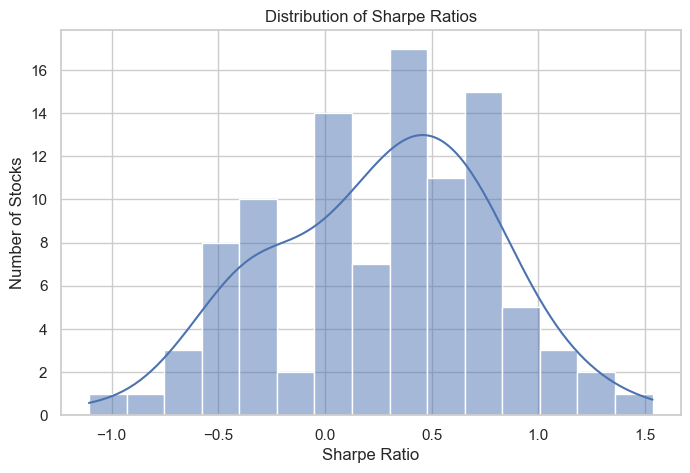

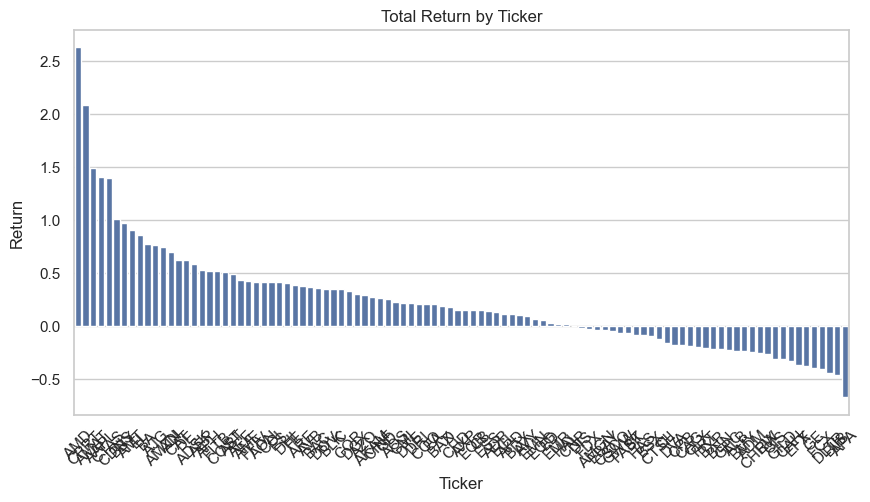

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame from performance summary
perf_df = pd.DataFrame(performance_summary)

# Display summary statistics
print("\n=== Summary Statistics ===")
print(perf_df.describe().round(4))

# Mean values
mean_metrics = perf_df[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(4))

# --- Plots ---
sns.set(style="whitegrid")

# 1. Histogram of Sharpe Ratios
plt.figure(figsize=(8, 5))
sns.histplot(perf_df['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()

# 2. Bar chart of Returns (sorted by Return)
plt.figure(figsize=(10, 5))
sorted_df = perf_df.sort_values(by='Return', ascending=False)
sns.barplot(x='Ticker', y='Return', data=sorted_df)
plt.title('Total Return by Ticker')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.show()

# 3. Optional: Save results to CSV
perf_df.to_csv('backtest_mavg_results_universal_params.csv', index=False)

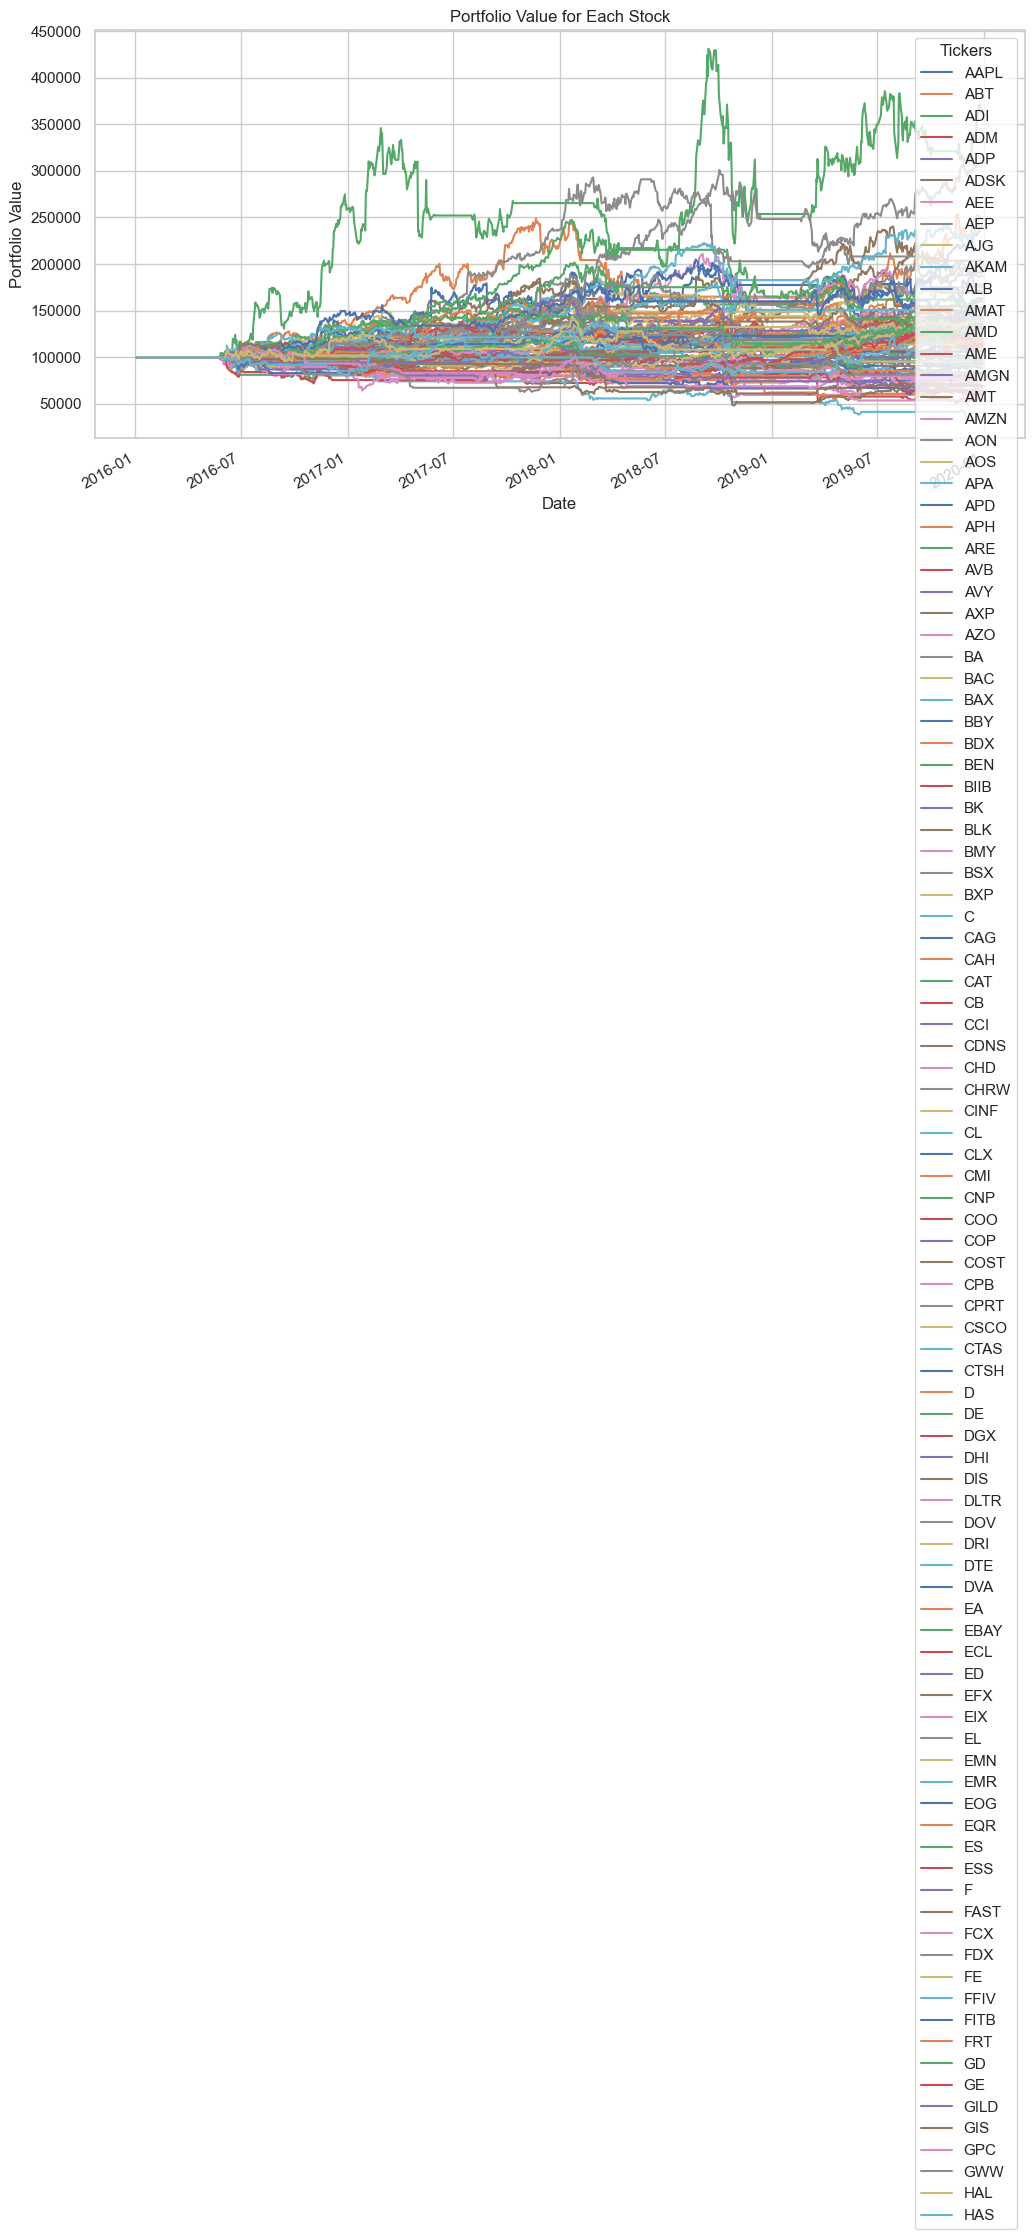

In [97]:
# Optionally, visualize overall performance of all stocks
# Combine all portfolio series
combined_portfolio = pd.concat(portfolio_series_list, axis=1)
combined_portfolio.plot(figsize=(12, 6))
plt.title('Portfolio Value for Each Stock')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Tickers')
plt.grid(True)
plt.show()

# 2. Momemtum

We start with a backtest of the strategy on a single stock, and plot the S&P 500 on the same timeframe to compare the results.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


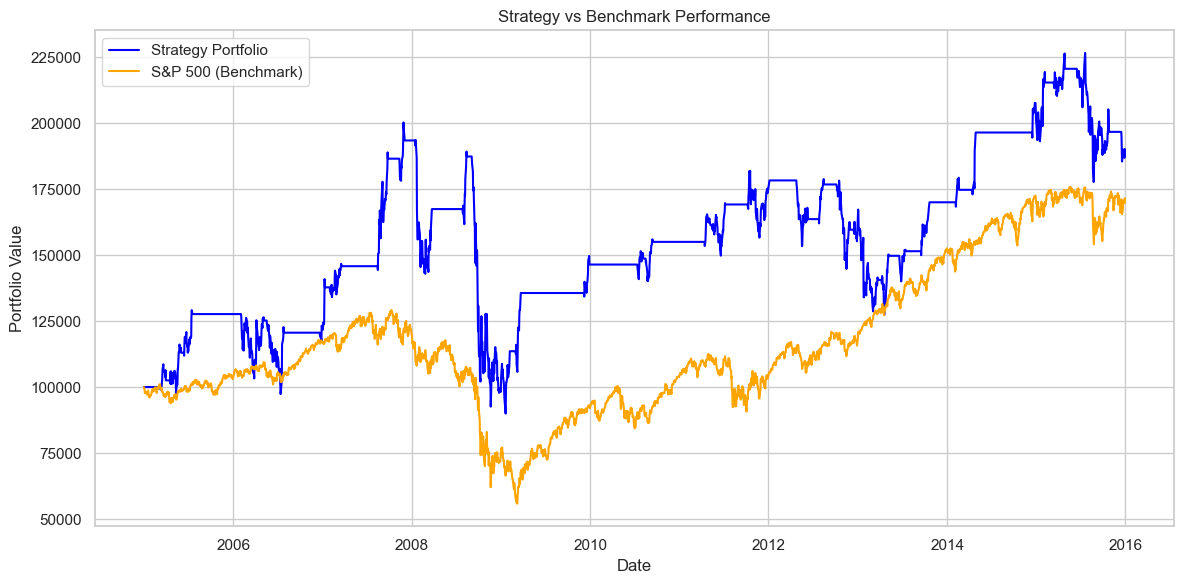

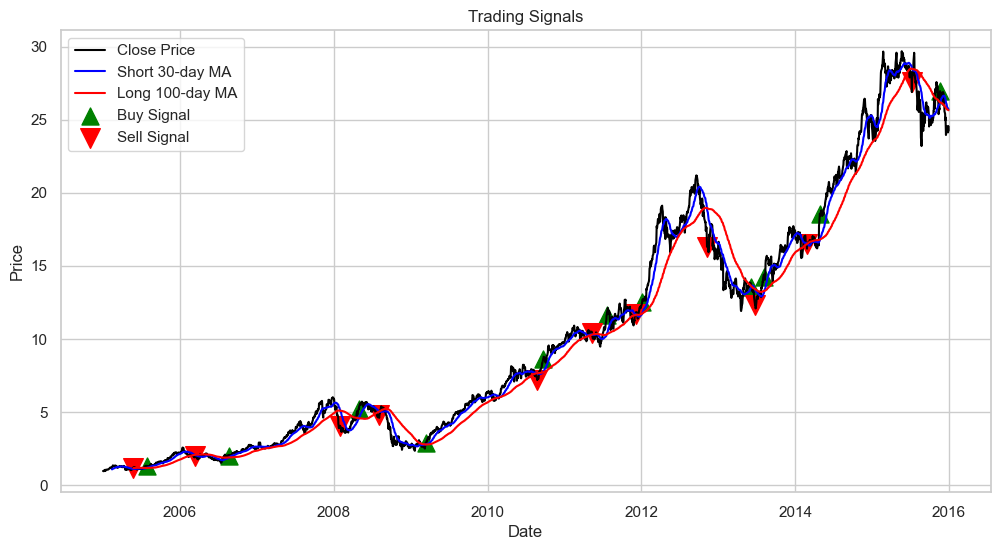

{'Final Value': 187672.33722039696, 'Return': 0.8767233722039696, 'Sharpe Ratio': 0.2746874102429567, 'Max Drawdown': -0.5506678589348195, 'Benchmark Return': 0.7025546509691731, 'Benchmark Sharpe Ratio': 0.2423450366797612, 'Benchmark Max Drawdown': -0.5677538774277291}


In [73]:
start_date = '2004-12-31'
end_date = '2015-12-31'
data_handler = DataHandler(ticker="AAPL", start_date=start_date, end_date=end_date)
data = data_handler.fetch_data()

# Load S&P 500 benchmark data
benchmark_data_handler = DataHandler("^GSPC", start_date, end_date)
benchmark_data = benchmark_data_handler.fetch_data()

my_momemtum = MomentumStrategy(period=14, overbought=70, oversold=30)
backtest = Backtest(data, my_momemtum, benchmark_data, risk_free_rate=0.02)
results = backtest.run()
moving_average_strategy.plot_signals(data)
print(results)


## 2.1 Backtesting "In Sample"
We use our backtester across 100 tickers and all the different combinations of parameters we have defined. For each simulation, we store the results and we will select after the best parameters sets for an out of sample performance analysis.

In [82]:
# RSI parameter grid
rsi_periods = [7, 14, 21]
overbought_levels = [65, 70, 75]
oversold_levels = [25, 30, 35]

# Result storage
all_results = {}
best_params = []

tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AJG", "AKAM",
    "ALB", "AMAT", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON", "AOS", "APA",
    "APD", "APH", "ARE", "AVB", "AVY", "AXP", "AZO", "BA", "BAC", "BAX",
    "BBY", "BDX", "BEN", "BIIB", "BK", "BLK", "BMY", "BSX", "BXP", "C",
    "CAG", "CAH", "CAT", "CB", "CCI", "CDNS", "CHD", "CHRW", "CINF", "CL",
    "CLX", "CMI", "CNP", "COO", "COP", "COST", "CPB", "CPRT", "CSCO", "CTAS",
    "CTSH", "D", "DE", "DGX", "DHI", "DIS", "DLTR", "DOV", "DRI", "DTE",
    "DVA", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR",
    "EOG", "EQR", "ES", "ESS", "F", "FAST", "FCX", "FDX", "FE", "FFIV",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
] 

# === GRID SEARCH PER TICKER ===
for ticker in tickers:
    print(f"\n🔍 Evaluating {ticker}")
    try:
        data_handler = DataHandler(ticker=ticker, start_date=start_date, end_date=end_date)
        data = data_handler.fetch_data()
        if data.empty:
            print(f"⚠️ No data for {ticker}")
            continue
    except Exception as e:
        print(f"❌ Error fetching data for {ticker}: {e}")
        continue

    results = []

    for period, overbought, oversold in product(rsi_periods, overbought_levels, oversold_levels):
        if oversold >= overbought:
            continue  # Invalid condition

        strategy = MomentumStrategy(period=period, overbought=overbought, oversold=oversold)
        backtest = Backtest(data=data, strategy=strategy, plot_results=False)

        try:
            result = backtest.run()
            results.append({
                'Ticker': ticker,
                'RSI Period': period,
                'Overbought': overbought,
                'Oversold': oversold,
                **result  # Merges Final Value, Return, Sharpe Ratio, Max Drawdown
            })
        except Exception as e:
            print(f"❌ Error | {ticker} | period={period}, ob={overbought}, os={oversold}: {e}")
            continue

    # Save all raw results
    all_results[ticker] = results

    # Select best Sharpe Ratio result
    if results:
        df = pd.DataFrame(results)
        best_row = df.loc[df['Sharpe Ratio'].idxmax()]
        best_params.append(best_row)

        # Optional: print top combinations
        print(df[['RSI Period', 'Overbought', 'Oversold', 'Sharpe Ratio', 'Return', 'Max Drawdown']].sort_values(by='Sharpe Ratio', ascending=False).head())
    else:
        print(f"⚠️ No valid results for {ticker}")

[*********************100%***********************]  1 of 1 completed


🔍 Evaluating AAPL


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
14          14          70        35      0.459405  1.560383     -0.599303
26          21          75        35      0.408365  1.199820     -0.527194
17          14          75        35      0.382337  1.084306     -0.576947
13          14          70        30      0.355442  0.876723     -0.550668
11          14          65        35      0.341256  0.810630     -0.587567

🔍 Evaluating ABT


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25      0.457612  0.763354     -0.167239
24          21          75        25      0.418383  0.699289     -0.289258
18          21          65        25      0.314216  0.316476     -0.151203
26          21          75        35      0.301112  0.490804     -0.313880
15          14          75        25      0.266568  0.351409     -0.181877

🔍 Evaluating ADI


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
13          14          70        30      0.323520  0.705709     -0.487773
16          14          75        30      0.321560  0.715306     -0.475086
14          14          70        35      0.262254  0.458826     -0.534311
17          14          75        35      0.258870  0.445713     -0.509992
15          14          75        25      0.247900  0.400371     -0.481914

🔍 Evaluating ADM


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.214303  0.258119     -0.614753
26          21          75        35      0.137443 -0.012340     -0.618223
24          21          75        25      0.120551 -0.018542     -0.590903
22          21          70        30      0.115853 -0.052038     -0.614761
21          21          70        25      0.078998 -0.100836     -0.590903

🔍 Evaluating ADP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.414812  0.541834     -0.124673
19          21          65        30      0.387088  0.612664     -0.181676
26          21          75        35      0.376733  0.789925     -0.328851
25          21          75        30      0.374232  0.745454     -0.318653
21          21          70        25      0.357533  0.529601     -0.196262

🔍 Evaluating ADSK


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
13          14          70        30      0.453941  1.700001     -0.651413
22          21          70        30      0.401272  1.258811     -0.627384
14          14          70        35      0.398979  1.294349     -0.654812
12          14          70        25      0.382448  1.087231     -0.622853
19          21          65        30      0.366470  0.996001     -0.625419

🔍 Evaluating AEE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.364531  0.813585     -0.585557
25          21          75        30      0.273239  0.457445     -0.585586
24          21          75        25      0.231708  0.325944     -0.556912
17          14          75        35      0.069002 -0.060047     -0.590685
15          14          75        25      0.060925 -0.041456     -0.423538

🔍 Evaluating AEP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.274071  0.458380     -0.480055
18          21          65        25      0.265470  0.307928     -0.150161
25          21          75        30      0.230388  0.321943     -0.480047
16          14          75        30      0.213015  0.275741     -0.405116
15          14          75        25      0.174737  0.182577     -0.312468

🔍 Evaluating AJG


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.389199  0.925067     -0.479164
20          21          65        35      0.366015  0.624795     -0.216841
19          21          65        30      0.338388  0.473478     -0.204948
23          21          70        35      0.332241  0.667279     -0.459900
16          14          75        30      0.309059  0.532656     -0.275886

🔍 Evaluating AKAM


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.432769  1.791031     -0.840645
17          14          75        35      0.380228  1.217968     -0.836267
14          14          70        35      0.357983  1.032038     -0.806299
12          14          70        25      0.317563  0.747232     -0.738142
25          21          75        30      0.311819  0.669531     -0.815898

🔍 Evaluating ALB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.533305  2.150731     -0.552802
16          14          75        30      0.448726  1.596026     -0.544670
19          21          65        30      0.390499  1.056011     -0.569657
18          21          65        25      0.373154  0.635667     -0.341550
12          14          70        25      0.369531  0.964147     -0.556612

🔍 Evaluating AMAT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.187568  0.169765     -0.617496
26          21          75        35      0.150652  0.030980     -0.617481
16          14          75        30      0.122102 -0.032015     -0.591015
15          14          75        25      0.117275 -0.027648     -0.592326
24          21          75        25      0.105078 -0.024782     -0.464478

🔍 Evaluating AMD


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25     -0.208195 -0.750498     -0.856449
15          14          75        25     -0.208597 -0.847071     -0.892834
12          14          70        25     -0.215649 -0.818248     -0.878044
23          21          70        35     -0.246781 -0.904563     -0.955949
26          21          75        35     -0.253030 -0.922592     -0.964004

🔍 Evaluating AME


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
23          21          70        35      0.585618  2.173225     -0.509985
17          14          75        35      0.562151  2.105190     -0.509999
26          21          75        35      0.533327  1.977734     -0.533085
16          14          75        30      0.527204  1.702945     -0.509990
20          21          65        35      0.434697  1.114363     -0.509979

🔍 Evaluating AMGN


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.442402  0.685932     -0.267564
26          21          75        35      0.337466  0.727008     -0.425605
25          21          75        30      0.318594  0.612463     -0.383515
22          21          70        30      0.262648  0.411469     -0.267095
19          21          65        30      0.258406  0.372408     -0.259542

🔍 Evaluating AMT


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      1.010542  3.581505     -0.189395
12          14          70        25      0.759613  1.775035     -0.131388
9           14          65        25      0.730088  1.483487     -0.110337
15          14          75        25      0.694370  1.930776     -0.197182
22          21          70        30      0.681516  1.367104     -0.164543

🔍 Evaluating AMZN


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.720485  6.848790     -0.636046
25          21          75        30      0.628206  4.170513     -0.653934
12          14          70        25      0.586558  1.904435     -0.330910
15          14          75        25      0.576594  2.097618     -0.396714
22          21          70        30      0.570427  1.647349     -0.309302

🔍 Evaluating AON


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.617262  1.795741     -0.226642
22          21          70        30      0.569782  1.396840     -0.275576
16          14          75        30      0.550598  1.636697     -0.243586
26          21          75        35      0.507230  1.328567     -0.226643
24          21          75        25      0.503412  0.874039     -0.164448

🔍 Evaluating AOS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
10          14          65        30      0.648173  2.718557     -0.306709
12          14          70        25      0.604207  2.113106     -0.295984
13          14          70        30      0.593754  2.468005     -0.360538
23          21          70        35      0.574203  2.439126     -0.407599
26          21          75        35      0.549471  2.583072     -0.382506

🔍 Evaluating APA


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.254121  0.420841     -0.575811
23          21          70        35      0.200664  0.167398     -0.652690
22          21          70        30      0.180022  0.099991     -0.607194
21          21          70        25      0.154514  0.122655     -0.580059
26          21          75        35      0.120162 -0.142734     -0.667625

🔍 Evaluating APD


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.309025  0.622291     -0.575231
16          14          75        30      0.284794  0.512746     -0.552449
25          21          75        30      0.267111  0.450790     -0.507527
20          21          65        35      0.262289  0.420023     -0.575225
15          14          75        25      0.247078  0.379308     -0.552502

🔍 Evaluating APH


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.514109  2.089780     -0.585215
26          21          75        35      0.499195  2.010578     -0.585214
24          21          75        25      0.466855  1.455106     -0.427879
17          14          75        35      0.417454  1.317396     -0.634135
16          14          75        30      0.394079  1.133207     -0.634136

🔍 Evaluating ARE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
22          21          70        30      0.503013  1.973426     -0.534502
19          21          65        30      0.433451  1.387576     -0.534527
25          21          75        30      0.387133  1.165791     -0.558654
23          21          70        35      0.308993  0.681751     -0.703267
15          14          75        25      0.283067  0.544193     -0.649337

🔍 Evaluating AVB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.507909  0.908500     -0.203541
18          21          65        25      0.358082  0.227244     -0.078169
24          21          75        25      0.316959  0.338064     -0.166728
21          21          70        25      0.301532  0.251726     -0.138080
17          14          75        35      0.292644  0.580349     -0.679260

🔍 Evaluating AVY


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.215964  0.288820     -0.452019
20          21          65        35      0.140968  0.079555     -0.569635
10          14          65        30      0.070072 -0.062323     -0.576970
21          21          70        25      0.069509 -0.075129     -0.582155
26          21          75        35      0.051377 -0.189967     -0.728964

🔍 Evaluating AXP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
10          14          65        30      0.262821  0.465965     -0.576547
18          21          65        25      0.237899  0.265431     -0.206048
25          21          75        30      0.228459  0.247952     -0.796473
26          21          75        35      0.195920  0.073736     -0.839033
16          14          75        30      0.188589  0.107838     -0.799921

🔍 Evaluating AZO


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.531211  1.566661     -0.368558
25          21          75        30      0.527117  1.475071     -0.368610
24          21          75        25      0.421331  0.856010     -0.368703
9           14          65        25      0.421311  0.771833     -0.269149
19          21          65        30      0.417758  0.874537     -0.300094

🔍 Evaluating BA


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.329206  0.744914     -0.669428
25          21          75        30      0.263395  0.456026     -0.652827
13          14          70        30      0.166109  0.157554     -0.489976
12          14          70        25      0.161510  0.153405     -0.483354
23          21          70        35      0.149172  0.098449     -0.671621

🔍 Evaluating BAC


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.095564 -0.285378     -0.642682
25          21          75        30      0.055854 -0.690716     -0.934445
24          21          75        25      0.053784 -0.681567     -0.926931
26          21          75        35      0.013969 -0.768298     -0.934431
22          21          70        30     -0.007899 -0.771467     -0.926959

🔍 Evaluating BAX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.369240  0.593490     -0.192529
24          21          75        25      0.357707  0.414371     -0.192855
25          21          75        30      0.321175  0.532887     -0.380741
16          14          75        30      0.318194  0.565763     -0.325667
26          21          75        35      0.313589  0.563602     -0.390316

🔍 Evaluating BBY


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
12          14          70        25      0.273205  0.505881     -0.496565
15          14          75        25      0.234756  0.339177     -0.547190
9           14          65        25      0.170969  0.138844     -0.497457
18          21          65        25      0.075992 -0.101732     -0.433848
21          21          70        25      0.065264 -0.166588     -0.570310

🔍 Evaluating BDX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.304152  0.496698     -0.336483
26          21          75        35      0.299971  0.463196     -0.321302
24          21          75        25      0.288598  0.274221     -0.135353
16          14          75        30      0.230837  0.298104     -0.335244
21          21          70        25      0.228238  0.194284     -0.135351

🔍 Evaluating BEN


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.290363  0.589615     -0.505634
16          14          75        30      0.259718  0.430698     -0.560677
25          21          75        30      0.244709  0.342962     -0.724996
12          14          70        25      0.232876  0.348349     -0.341134
19          21          65        30      0.224679  0.310097     -0.497501

🔍 Evaluating BIIB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.515538  2.138074     -0.381108
14          14          70        35      0.449275  1.490097     -0.330188
26          21          75        35      0.443895  1.543840     -0.412641
23          21          70        35      0.365234  0.926745     -0.408474
6            7          75        25      0.334017  0.741048     -0.433437

🔍 Evaluating BK


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.422221  1.235220     -0.365709
21          21          70        25      0.300991  0.604154     -0.365710
13          14          70        30      0.265821  0.481498     -0.416907
25          21          75        30      0.263044  0.344638     -0.624231
18          21          65        25      0.262888  0.425375     -0.365681

🔍 Evaluating BLK


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.528103  2.463828     -0.603531
25          21          75        30      0.442515  1.673411     -0.603544
18          21          65        25      0.441685  0.812315     -0.181026
26          21          75        35      0.431195  1.633587     -0.603576
12          14          70        25      0.350938  0.857760     -0.364576

🔍 Evaluating BMY


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.548972  1.773331     -0.426607
19          21          65        30      0.547560  1.181209     -0.267062
20          21          65        35      0.512226  1.210994     -0.344375
25          21          75        30      0.484973  1.342381     -0.426624
23          21          70        35      0.468474  1.103931     -0.393788

🔍 Evaluating BSX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25     -0.006465 -0.199289     -0.441736
21          21          70        25     -0.068521 -0.426588     -0.624725
10          14          65        30     -0.093520 -0.466655     -0.690683
13          14          70        30     -0.098332 -0.507405     -0.728412
19          21          65        30     -0.134449 -0.498924     -0.616861

🔍 Evaluating BXP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.486800  0.353239     -0.098156
24          21          75        25      0.418250  0.572288     -0.189043
21          21          70        25      0.303026  0.294203     -0.189102
19          21          65        30      0.236189  0.341752     -0.569939
25          21          75        30      0.232315  0.265585     -0.692067

🔍 Evaluating C


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
9           14          65        25      0.055650 -0.528462     -0.822732
21          21          70        25      0.052011 -0.695614     -0.965864
18          21          65        25     -0.001470 -0.763321     -0.969425
24          21          75        25     -0.083894 -0.888247     -0.979847
25          21          75        30     -0.101402 -0.904939     -0.979853

🔍 Evaluating CAG


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25      0.156433  0.137531     -0.299574
22          21          70        30      0.109275  0.063027     -0.310222
23          21          70        35      0.088795  0.016369     -0.355093
24          21          75        25      0.069223 -0.001496     -0.446533
26          21          75        35      0.064740 -0.034441     -0.471158

🔍 Evaluating CAH


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.157632  0.145838     -0.452178
26          21          75        35      0.134579  0.086110     -0.569528
24          21          75        25      0.133267  0.097995     -0.501992
25          21          75        30      0.128966  0.080817     -0.538540
18          21          65        25      0.126070  0.090201     -0.349883

🔍 Evaluating CAT


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.113862  0.003562     -0.560435
18          21          65        25      0.075943 -0.068013     -0.558385
20          21          65        35      0.063567 -0.140704     -0.612786
21          21          70        25      0.036581 -0.192331     -0.698050
23          21          70        35      0.022081 -0.271292     -0.729045

🔍 Evaluating CB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.653748  1.837517     -0.211132
22          21          70        30      0.639013  1.416611     -0.196556
26          21          75        35      0.545170  1.779675     -0.359312
23          21          70        35      0.515606  1.430904     -0.347759
21          21          70        25      0.461874  0.534863     -0.196525

🔍 Evaluating CCI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.458463  1.640355     -0.737688
23          21          70        35      0.408263  1.148399     -0.737689
6            7          75        25      0.357177  0.891480     -0.669014
17          14          75        35      0.325844  0.758982     -0.760058
16          14          75        30      0.325340  0.724588     -0.737702

🔍 Evaluating CDNS


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.145436 -0.136416     -0.866826
14          14          70        35      0.139955 -0.140046     -0.859153
26          21          75        35      0.106742 -0.247258     -0.892222
23          21          70        35      0.090252 -0.263667     -0.852002
20          21          65        35      0.009881 -0.432380     -0.838625

🔍 Evaluating CHD


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.743510  0.425977     -0.101337
26          21          75        35      0.636695  1.535838     -0.227452
21          21          70        25      0.609407  0.322231     -0.101331
23          21          70        35      0.561155  1.047248     -0.227465
15          14          75        25      0.476518  0.585113     -0.206426

🔍 Evaluating CHRW


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.535030  1.483757     -0.318305
10          14          65        30      0.531001  1.461804     -0.216386
9           14          65        25      0.502464  1.163312     -0.173129
12          14          70        25      0.480842  1.224898     -0.234300
13          14          70        30      0.460208  1.286942     -0.340949

🔍 Evaluating CINF


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.258763  0.441105     -0.592478
15          14          75        25      0.223812  0.319491     -0.492400
16          14          75        30      0.203448  0.256724     -0.503575
17          14          75        35      0.186502  0.203608     -0.510148
25          21          75        30      0.181492  0.148028     -0.584096

🔍 Evaluating CL


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.528574  0.874712     -0.200797
22          21          70        30      0.498371  0.793458     -0.200794
23          21          70        35      0.485784  0.919501     -0.223246
26          21          75        35      0.421724  0.752554     -0.207165
16          14          75        30      0.409777  0.696686     -0.178879

🔍 Evaluating CLX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.521702  1.029679     -0.261622
16          14          75        30      0.429990  0.746058     -0.263801
23          21          70        35      0.419607  0.661263     -0.293302
17          14          75        35      0.363745  0.602123     -0.298681
15          14          75        25      0.363196  0.463917     -0.234690

🔍 Evaluating CMI


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.385395  1.183839     -0.702246
16          14          75        30      0.323285  0.774549     -0.756622
12          14          70        25      0.313519  0.710417     -0.707350
25          21          75        30      0.306476  0.672045     -0.694430
13          14          70        30      0.256873  0.403509     -0.755494

🔍 Evaluating CNP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.401784  0.694024     -0.229168
24          21          75        25      0.307889  0.549735     -0.374107
21          21          70        25      0.299853  0.482650     -0.374106
17          14          75        35      0.193524  0.225594     -0.562144
16          14          75        30      0.156635  0.130997     -0.529105

🔍 Evaluating COO


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35     -0.029458 -0.426957     -0.827881
21          21          70        25     -0.088858 -0.349596     -0.682670
20          21          65        35     -0.095465 -0.462720     -0.769641
18          21          65        25     -0.096204 -0.347202     -0.648310
24          21          75        25     -0.118741 -0.407316     -0.671784

🔍 Evaluating COP


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.363218  0.646101     -0.406405
18          21          65        25      0.354357  0.464947     -0.219578
15          14          75        25      0.191552  0.211680     -0.541999
21          21          70        25      0.170070  0.157746     -0.380743
19          21          65        30      0.152907  0.101605     -0.512303

🔍 Evaluating COST


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.577862  1.617330     -0.349758
25          21          75        30      0.551239  1.240118     -0.349775
17          14          75        35      0.370372  0.738607     -0.399236
15          14          75        25      0.359727  0.555114     -0.349733
22          21          70        30      0.356978  0.566158     -0.349771

🔍 Evaluating CPB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
23          21          70        35      0.547275  0.959180     -0.280559
21          21          70        25      0.510247  0.545020     -0.108921
18          21          65        25      0.444522  0.397132     -0.108919
26          21          75        35      0.442145  0.740829     -0.350547
20          21          65        35      0.428796  0.637012     -0.280579

🔍 Evaluating CPRT


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
20          21          65        35      0.653121  2.258224     -0.415618
24          21          75        25      0.650561  2.146753     -0.360966
26          21          75        35      0.595030  2.397543     -0.498489
13          14          70        30      0.528129  1.418952     -0.404210
25          21          75        30      0.521296  1.606146     -0.498490

🔍 Evaluating CSCO


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
22          21          70        30      0.386030  0.904318     -0.390035
19          21          65        30      0.360618  0.637124     -0.323326
25          21          75        30      0.307863  0.639403     -0.531301
21          21          70        25      0.226505  0.274558     -0.336437
24          21          75        25      0.161132  0.139393     -0.505421

🔍 Evaluating CTAS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.270019  0.449532     -0.467416
24          21          75        25      0.251812  0.364726     -0.385586
26          21          75        35      0.224924  0.320013     -0.485872
23          21          70        35      0.222181  0.309957     -0.469381
22          21          70        30      0.213649  0.281610     -0.451884

🔍 Evaluating CTSH


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.522110  2.583820     -0.584700
16          14          75        30      0.450178  1.662755     -0.536064
12          14          70        25      0.405833  1.177385     -0.447496
14          14          70        35      0.386055  1.189528     -0.562044
13          14          70        30      0.373097  1.048454     -0.492906

🔍 Evaluating D


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.440845  0.867873     -0.380207
12          14          70        25      0.375337  0.515799     -0.170388
13          14          70        30      0.353754  0.507981     -0.192059
25          21          75        30      0.321336  0.493225     -0.373377
14          14          70        35      0.316169  0.479317     -0.234478

🔍 Evaluating DE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
9           14          65        25      0.276741  0.482008     -0.406115
22          21          70        30      0.179381  0.176613     -0.639864
17          14          75        35      0.170711  0.091039     -0.720225
21          21          70        25      0.138036  0.072021     -0.606423
14          14          70        35      0.132290 -0.011783     -0.680357

🔍 Evaluating DGX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.521548  1.413089     -0.286379
26          21          75        35      0.351724  0.741574     -0.297714
22          21          70        30      0.320890  0.554748     -0.245059
15          14          75        25      0.295212  0.474688     -0.220352
24          21          75        25      0.289937  0.471533     -0.286318

🔍 Evaluating DHI


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
11          14          65        35      0.496017  2.700789     -0.775142
14          14          70        35      0.463213  2.252969     -0.795730
3            7          70        25      0.450335  1.965761     -0.605880
20          21          65        35      0.448253  2.034278     -0.590610
10          14          65        30      0.418287  1.599086     -0.755151

🔍 Evaluating DIS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.433350  1.305184     -0.539846
25          21          75        30      0.361372  0.855185     -0.539820
24          21          75        25      0.331044  0.696731     -0.539811
19          21          65        30      0.274926  0.446025     -0.407784
21          21          70        25      0.196906  0.239434     -0.539824

🔍 Evaluating DLTR


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.679013  1.996225     -0.397431
26          21          75        35      0.580042  2.645616     -0.509766
25          21          75        30      0.552101  2.205687     -0.509781
21          21          70        25      0.466115  0.950918     -0.430594
23          21          70        35      0.307944  0.643139     -0.509765

🔍 Evaluating DOV


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25      0.623201  1.805551     -0.285296
18          21          65        25      0.554461  1.309136     -0.269630
24          21          75        25      0.499533  1.482457     -0.375776
25          21          75        30      0.362731  0.937909     -0.562020
22          21          70        30      0.266163  0.457624     -0.542390

🔍 Evaluating DRI


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25      0.492768  1.104803     -0.408474
17          14          75        35      0.396915  1.260261     -0.716859
18          21          65        25      0.371407  0.626515     -0.408474
25          21          75        30      0.370537  1.012376     -0.668161
16          14          75        30      0.357818  0.974074     -0.720649

🔍 Evaluating DTE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
21          21          70        25      0.272049  0.337460     -0.233072
18          21          65        25      0.245003  0.274110     -0.233072
19          21          65        30      0.189853  0.201290     -0.270419
20          21          65        35      0.189789  0.209382     -0.279268
26          21          75        35      0.181042  0.197786     -0.495373

🔍 Evaluating DVA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.437858  1.147236     -0.314825
23          21          70        35      0.421978  1.033059     -0.314808
25          21          75        30      0.367188  0.770106     -0.306341
22          21          70        30      0.350622  0.698329     -0.306373
20          21          65        35      0.233461  0.329926     -0.314793

🔍 Evaluating EA


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.111224 -0.189857     -0.784821
20          21          65        35      0.097633 -0.172459     -0.738483
18          21          65        25      0.095061 -0.091232     -0.608683
19          21          65        30      0.072195 -0.157740     -0.624805
23          21          70        35      0.068542 -0.291837     -0.761585

🔍 Evaluating EBAY


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
12          14          70        25      0.414006  1.144977     -0.462828
26          21          75        35      0.408961  1.411913     -0.702224
25          21          75        30      0.254310  0.409409     -0.702228
15          14          75        25      0.242083  0.384210     -0.570752
21          21          70        25      0.230263  0.314065     -0.327760

🔍 Evaluating ECL


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.467708  1.238811     -0.397845
19          21          65        30      0.437012  0.422612     -0.104605
20          21          65        35      0.419701  0.781096     -0.227100
23          21          70        35      0.357325  0.719959     -0.397868
25          21          75        30      0.322627  0.581899     -0.397782

🔍 Evaluating ED


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.516355  1.030288     -0.265999
23          21          70        35      0.430706  0.690857     -0.193510
21          21          70        25      0.330838  0.310804     -0.146607
17          14          75        35      0.229565  0.279338     -0.248657
16          14          75        30      0.215027  0.243209     -0.244223

🔍 Evaluating EFX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.352578  0.699540     -0.309645
21          21          70        25      0.351895  0.630386     -0.285021
26          21          75        35      0.275134  0.478502     -0.518552
16          14          75        30      0.262274  0.430537     -0.359881
19          21          65        30      0.242918  0.348713     -0.309643

🔍 Evaluating EIX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.481690  0.995047     -0.339308
25          21          75        30      0.363167  0.716343     -0.503999
26          21          75        35      0.354772  0.776845     -0.550176
16          14          75        30      0.222223  0.303185     -0.518873
21          21          70        25      0.206936  0.231260     -0.339308

🔍 Evaluating EL


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
23          21          70        35      0.410271  1.089169     -0.435519
26          21          75        35      0.262412  0.459987     -0.621017
21          21          70        25      0.248030  0.356336     -0.410705
22          21          70        30      0.239611  0.354959     -0.412736
20          21          65        35      0.229231  0.329877     -0.492502

🔍 Evaluating EMN


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.241034  0.373262     -0.737612
22          21          70        30      0.168457  0.132227     -0.739993
9           14          65        25      0.164271  0.145056     -0.490699
12          14          70        25      0.138937  0.069031     -0.630623
15          14          75        25      0.128672  0.016017     -0.744753

🔍 Evaluating EMR


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
20          21          65        35      0.428483  1.123094     -0.405824
19          21          65        30      0.408678  0.965732     -0.405812
22          21          70        30      0.319506  0.661337     -0.498554
25          21          75        30      0.315286  0.673896     -0.561096
17          14          75        35      0.289691  0.577771     -0.544441

🔍 Evaluating EOG


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
18          21          65        25      0.961980  2.028572     -0.149845
21          21          70        25      0.751048  2.245534     -0.219527
24          21          75        25      0.431300  0.981523     -0.324189
11          14          65        35      0.363375  0.995515     -0.454500
9           14          65        25      0.336084  0.703288     -0.358071

🔍 Evaluating EQR


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.642850  1.459505     -0.244424
26          21          75        35      0.341552  0.890185     -0.653942
20          21          65        35      0.330569  0.826103     -0.517439
18          21          65        25      0.311606  0.254170     -0.128740
10          14          65        30      0.293624  0.605978     -0.460238

🔍 Evaluating ES


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.617036  0.964925     -0.180656
26          21          75        35      0.438884  1.008763     -0.406177
21          21          70        25      0.372142  0.387498     -0.169646
25          21          75        30      0.363890  0.706654     -0.372297
15          14          75        25      0.311865  0.474255     -0.254190

🔍 Evaluating ESS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.550315  0.981563     -0.229486
22          21          70        30      0.443782  0.756661     -0.237667
18          21          65        25      0.285360  0.323478     -0.215809
25          21          75        30      0.262621  0.450849     -0.597193
9           14          65        25      0.257504  0.323666     -0.298349

🔍 Evaluating F


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
15          14          75        25      0.353221  1.004422     -0.724384
12          14          70        25      0.318858  0.772292     -0.676931
13          14          70        30      0.187291  0.094423     -0.642144
9           14          65        25      0.167423  0.085151     -0.624736
26          21          75        35      0.077916 -0.400717     -0.867784

🔍 Evaluating FAST


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.506998  1.542558     -0.363365
22          21          70        30      0.472645  1.450498     -0.363372
12          14          70        25      0.392419  0.980735     -0.303239
25          21          75        30      0.385161  1.031763     -0.363366
18          21          65        25      0.320969  0.617353     -0.363363

🔍 Evaluating FCX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.018400 -0.446491     -0.785730
17          14          75        35     -0.050448 -0.744758     -0.873358
20          21          65        35     -0.062997 -0.702896     -0.890311
26          21          75        35     -0.075207 -0.759659     -0.915461
16          14          75        30     -0.080385 -0.760014     -0.874811

🔍 Evaluating FDX


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.142160  0.023022     -0.713069
17          14          75        35      0.137611  0.014521     -0.664133
15          14          75        25      0.134201  0.045983     -0.653454
20          21          65        35      0.126851  0.045274     -0.538746
16          14          75        30      0.093175 -0.081396     -0.620514

🔍 Evaluating FE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.120068  0.030557     -0.509119
12          14          70        25      0.099398  0.024715     -0.303269
25          21          75        30      0.020053 -0.170016     -0.507479
15          14          75        25      0.013585 -0.153366     -0.388870
9           14          65        25     -0.008358 -0.133689     -0.385646

🔍 Evaluating FFIV


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
8            7          75        35      0.352595  0.993623     -0.653444
6            7          75        25      0.289139  0.582499     -0.637571
7            7          75        30      0.258113  0.398651     -0.653277
24          21          75        25      0.256116  0.433999     -0.416261
16          14          75        30      0.254897  0.393469     -0.577999

🔍 Evaluating FITB


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
22          21          70        30      0.135785 -0.288742     -0.891477
21          21          70        25      0.124647 -0.310627     -0.876488
19          21          65        30      0.006396 -0.599620     -0.895613
24          21          75        25     -0.004225 -0.789166     -0.964976
25          21          75        30     -0.017910 -0.815904     -0.973973

🔍 Evaluating FRT


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
19          21          65        30      0.424964  1.420933     -0.410169
20          21          65        35      0.416111  1.406139     -0.410190
26          21          75        35      0.385886  1.226075     -0.574162
25          21          75        30      0.363289  1.043237     -0.574155
17          14          75        35      0.336067  0.860799     -0.575389

🔍 Evaluating GD


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.522065  1.539663     -0.511003
25          21          75        30      0.362482  0.693758     -0.490181
23          21          70        35      0.294655  0.497421     -0.488439
16          14          75        30      0.192330  0.224852     -0.569335
15          14          75        25      0.140814  0.109929     -0.569338

🔍 Evaluating GE


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
9           14          65        25      0.353171  0.710024     -0.509531
26          21          75        35      0.198456  0.204680     -0.816359
25          21          75        30      0.162147  0.090947     -0.817157
23          21          70        35      0.091484 -0.102545     -0.791714
24          21          75        25      0.088680 -0.078132     -0.788329

🔍 Evaluating GILD


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
16          14          75        30      0.609554  2.650381     -0.336640
17          14          75        35      0.570225  2.475644     -0.380000
26          21          75        35      0.482521  1.601788     -0.414134
15          14          75        25      0.455651  1.110944     -0.301399
14          14          70        35      0.450905  1.343701     -0.370326

🔍 Evaluating GIS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
26          21          75        35      0.565611  1.291231     -0.317613
25          21          75        30      0.557425  1.025846     -0.317606
13          14          70        30      0.440968  0.620189     -0.220518
23          21          70        35      0.438349  0.714667     -0.299443
17          14          75        35      0.412562  0.675963     -0.299444

🔍 Evaluating GPC


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
17          14          75        35      0.359176  0.706790     -0.473078
14          14          70        35      0.350607  0.619020     -0.459574
18          21          65        25      0.339412  0.434029     -0.176934
16          14          75        30      0.314723  0.529163     -0.478301
26          21          75        35      0.297414  0.518552     -0.470208

🔍 Evaluating GWW


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
16          14          75        30      0.562984  1.699713     -0.277673
17          14          75        35      0.495799  1.444549     -0.401976
18          21          65        25      0.472455  0.482236     -0.121431
15          14          75        25      0.388993  0.799555     -0.277737
20          21          65        35      0.387092  0.777985     -0.277732

🔍 Evaluating HAL


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
24          21          75        25      0.209955  0.242509     -0.596673
21          21          70        25      0.140082  0.012022     -0.589949
11          14          65        35      0.117059 -0.141510     -0.724216
26          21          75        35      0.113009 -0.180008     -0.714609
23          21          70        35      0.110812 -0.176576     -0.731672

🔍 Evaluating HAS


[*********************100%***********************]  1 of 1 completed


    RSI Period  Overbought  Oversold  Sharpe Ratio    Return  Max Drawdown
25          21          75        30      0.418244  1.044553     -0.435961
22          21          70        30      0.390709  0.802368     -0.335740
19          21          65        30      0.351216  0.640528     -0.391632
26          21          75        35      0.336614  0.747992     -0.475559
24          21          75        25      0.333923  0.633760     -0.411109


In [83]:
# === FINAL SUMMARY ===
best_params_df = pd.DataFrame(best_params)

print("\n=== ✅ Best Parameters per Ticker ===")
print(best_params_df[['Ticker', 'RSI Period', 'Overbought', 'Oversold', 'Sharpe Ratio', 'Return', 'Max Drawdown']].round(4))

# Optional: Find global best
global_best = best_params_df.loc[best_params_df['Sharpe Ratio'].idxmax()]
print("\n🏆 Global Best Sharpe Ratio:")
print(global_best[['Ticker', 'RSI Period', 'Overbought', 'Oversold', 'Sharpe Ratio']])


=== ✅ Best Parameters per Ticker ===
   Ticker  RSI Period  Overbought  Oversold  Sharpe Ratio  Return  \
14   AAPL          14          70        35        0.4594  1.5604   
21    ABT          21          70        25        0.4576  0.7634   
13    ADI          14          70        30        0.3235  0.7057   
25    ADM          21          75        30        0.2143  0.2581   
18    ADP          21          65        25        0.4148  0.5418   
..    ...         ...         ...       ...           ...     ...   
26    GIS          21          75        35        0.5656  1.2912   
17    GPC          14          75        35        0.3592  0.7068   
16    GWW          14          75        30        0.5630  1.6997   
24    HAL          21          75        25        0.2100  0.2425   
25    HAS          21          75        30        0.4182  1.0446   

    Max Drawdown  
14       -0.5993  
21       -0.1672  
13       -0.4878  
25       -0.6148  
18       -0.1247  
..           ...  


The best parameters combination are period = 21, overbought = 75, Oversold = 30

## 2.2 Out of Sample Backtesting

In [90]:
performance_summary_momemtum = []
portfolio_series_list_momemtum = []

for ticker in tickers:
    print(f"\n📈 Backtesting {ticker} with most common params")

    data_handler = DataHandler(ticker=ticker, start_date=out_of_sample_start_date, end_date=out_of_sample_end_date)
    data = data_handler.fetch_data()

    strategy = MomentumStrategy(period=21, overbought=75, oversold=30)
    backtest = Backtest(data, strategy, plot_results=False)
    result = backtest.run()
    portfolio_series = backtest.get_portfolio_value_series()
    portfolio_series_list_momemtum.append(portfolio_series.rename(ticker))

    performance_summary_momemtum.append({
        'Ticker': ticker,
        'Final Value': result['Final Value'],
        'Return': result['Return'],
        'Sharpe Ratio': result['Sharpe Ratio'],
        'Max Drawdown': result['Max Drawdown']
    })

# Make a DataFrame
perf_df_momemtum = pd.DataFrame(performance_summary)


📈 Backtesting AAPL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ABT with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting ADI with most common params



📈 Backtesting ADM with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ADP with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting ADSK with most common params



📈 Backtesting AEE with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AEP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AJG with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AKAM with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ALB with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMAT with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMD with most common params



📈 Backtesting AME with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMGN with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMT with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting AMZN with most common params



📈 Backtesting AON with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AOS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting APA with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting APD with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting APH with most common params



📈 Backtesting ARE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AVB with most common params



📈 Backtesting AVY with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting AXP with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting AZO with most common params



📈 Backtesting BA with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BAC with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BAX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BBY with most common params



📈 Backtesting BDX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BEN with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting BIIB with most common params



📈 Backtesting BK with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BLK with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting BMY with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting BSX with most common params



📈 Backtesting BXP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting C with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAG with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAH with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CAT with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CB with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CCI with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting CDNS with most common params



📈 Backtesting CHD with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CHRW with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CINF with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CLX with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CMI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CNP with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting COO with most common params



📈 Backtesting COP with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting COST with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting CPB with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting CPRT with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting CSCO with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting CTAS with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting CTSH with most common params



📈 Backtesting D with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting DGX with most common params



📈 Backtesting DHI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DIS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DLTR with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DOV with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DRI with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting DTE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting DVA with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting EA with most common params



📈 Backtesting EBAY with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ECL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting ED with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting EFX with most common params



📈 Backtesting EIX with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EL with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting EMN with most common params



📈 Backtesting EMR with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting EOG with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting EQR with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting ES with most common params



📈 Backtesting ESS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting F with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting FAST with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting FCX with most common params



📈 Backtesting FDX with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting FE with most common params



📈 Backtesting FFIV with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting FITB with most common params



[*********************100%***********************]  1 of 1 completed


📈 Backtesting FRT with most common params



📈 Backtesting GD with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GE with most common params


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Backtesting GILD with most common params



📈 Backtesting GIS with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GPC with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting GWW with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting HAL with most common params


[*********************100%***********************]  1 of 1 completed



📈 Backtesting HAS with most common params


[*********************100%***********************]  1 of 1 completed



=== Summary Statistics ===
       Final Value    Return  Sharpe Ratio  Max Drawdown
count     100.0000  100.0000      100.0000      100.0000
mean   123021.4510    0.2302        0.2681       -0.2903
std     51299.9137    0.5130        0.5138        0.1133
min     33051.2392   -0.6695       -1.1063       -0.6695
25%     90395.6575   -0.0960       -0.0707       -0.3553
50%    115844.6197    0.1584        0.3418       -0.2685
75%    141703.1481    0.4170        0.6599       -0.2006
max    362875.1710    2.6288        1.5350       -0.1182

=== Mean Metrics ===
Return               0.2302
Sharpe Ratio         0.2681
Final Value     123021.4510
Max Drawdown        -0.2903
dtype: float64


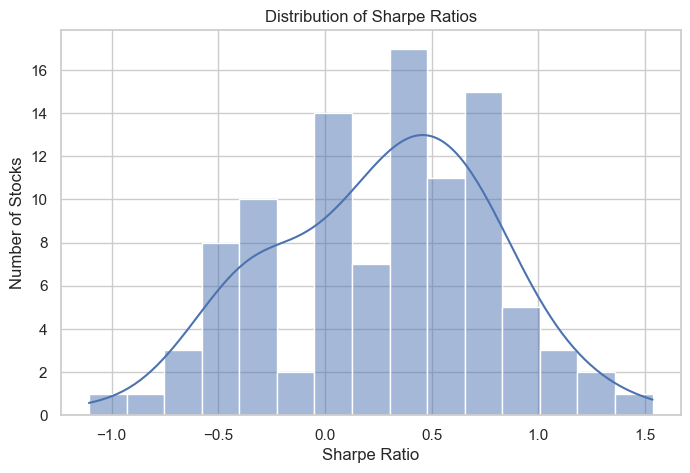

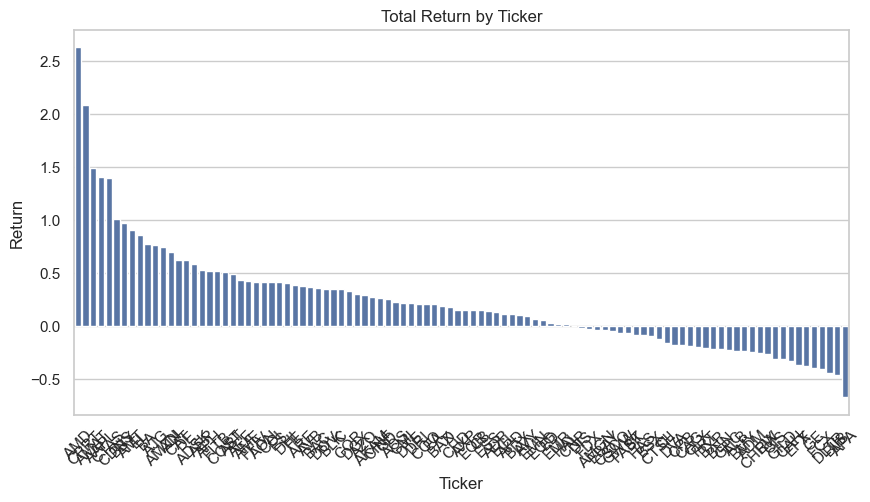

In [95]:
# Display summary statistics
print("\n=== Summary Statistics ===")
print(perf_df_momemtum.describe().round(4))

# Mean values
mean_metrics = perf_df_momemtum[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(4))

# --- Plots ---
sns.set(style="whitegrid")

# 1. Histogram of Sharpe Ratios
plt.figure(figsize=(8, 5))
sns.histplot(perf_df_momemtum['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()

# 2. Bar chart of Returns (sorted by Return)
plt.figure(figsize=(10, 5))
sorted_df = perf_df_momemtum.sort_values(by='Return', ascending=False)
sns.barplot(x='Ticker', y='Return', data=sorted_df)
plt.title('Total Return by Ticker')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.show()

# 3. Optional: Save results to CSV
perf_df_momemtum.to_csv('backtest_momemtum_results_universal_params.csv', index=False)

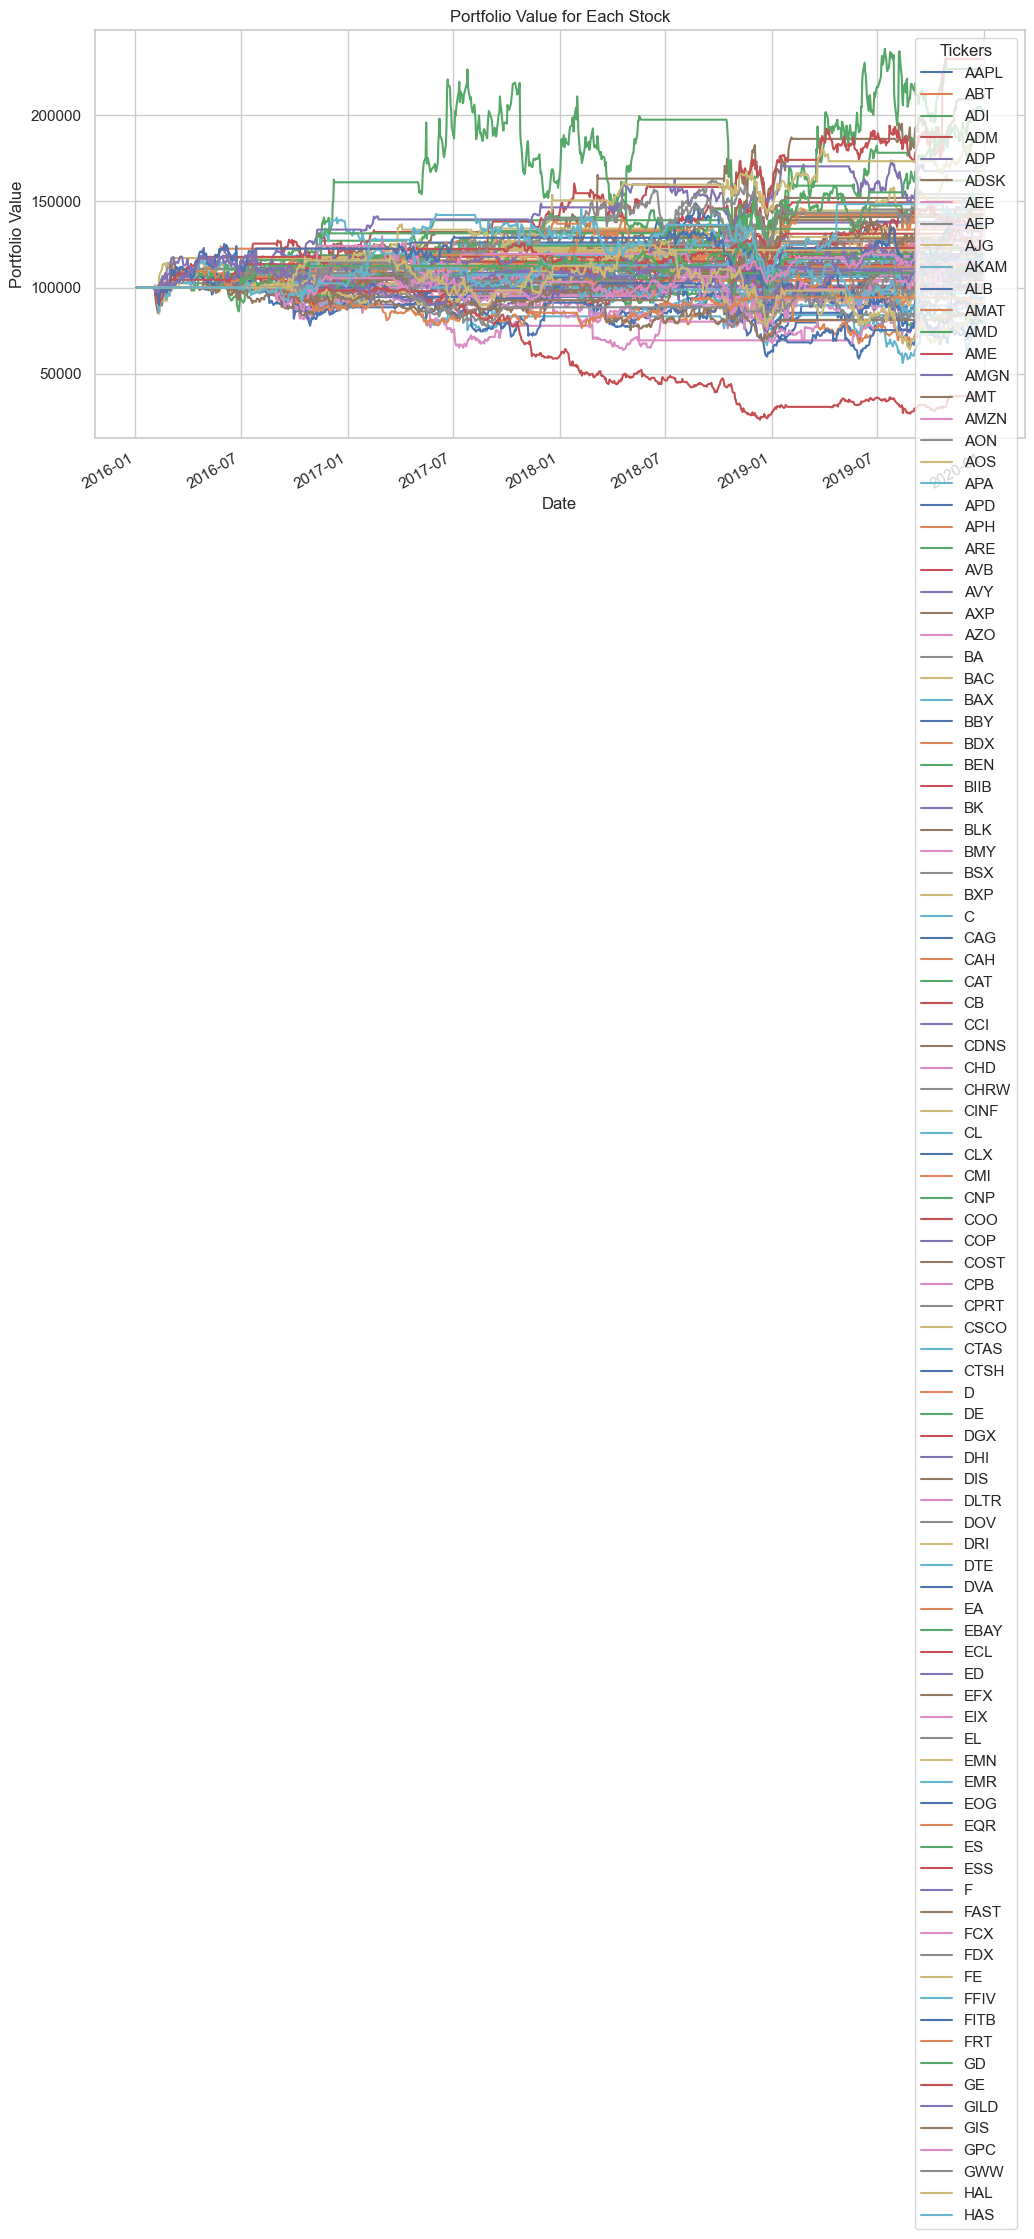

In [99]:
# Optionally, visualize overall performance of all stocks
# Combine all portfolio series
combined_portfolio_momemtum = pd.concat(portfolio_series_list_momemtum, axis=1)
combined_portfolio_momemtum.plot(figsize=(12, 6))
plt.title('Portfolio Value for Each Stock')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Tickers')
plt.grid(True)
plt.show()
